# Мобильная игра "Космические братья". Новая модель монетизации

Исследование было запрошено менеджерами мобильной игры "Космические братья". Разработчики хотят внедрить монетизацию и при этом не быть назойливыми и раздражающими для своих пользователей. В настоящее время в планах внедрение рекламного банера на экран постройки, но заказчик исследования хочет рассмотреть другие модели монетизации.

В нашем распоряжении данные о когортах пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно (пользователи привлеченные разными рекламными каналами). Известны расходы на привлечение пользователей, прибыль с показа одной рекламы (0,07 у.е.), типы событий и построенных объектов с датой-временем совершения действия.

Для работы были предоставленны три датасета: ad_costs.csv (рсходы на рекламу), game_actions.csv (внутри игровые действия) и user_source.csv (канал прилечения пользователя). 

Результатом исследования станут полный текст исследования в JupiterNotebook, презентация с основными выводами в формате pdf и интерактивный дешборд в Tableau

# Глобальная задача

Выбор новой модели монетизации, вызывающей меньшее раздражение у игроков, при этом все еще окупающейся

# Подзадачи

* Изучить поведение пользователей в игре (количество строений, срок нахождения в игре, способ перехода на второй уровень и процент игроков, не забросивших игру и перешедших на второй уровень);
* Оценить текущую модель монетизации исходя из доступной информации о расходах на привленичений пользователей авансовыми платежами по дням и стоимости показа одной баннерной рекламы;
* Сравнение количества игроков с разной стратегией; 

# Гипотезы 
* Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком различается.
* PVE пользователи чаще чем PVP пользователи строят постройки типа research_center 

# Материалы 
* Презентация (https://disk.yandex.ru/i/HB6Ee3fxmaPceQ)
* Дашборд (https://public.tableau.com/views/_16832072302570/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

# Оглавление
1. [Выгрузка данных, общая информация и предобработка](#start)
    * [Изучение и предобработка ad_costs.csv](#cost)
    * [Изучение и предобработка game_actions.csv](#action)
    * [Изучение и предобработка user_source.csv](#source)
    * [Результаты предобработки](#results)
2. [Анализ пользовательского поведения](#analise)
3. [Оценка расходов и стоимости привлечения пользователя по дням](#costs)
    * [Распределение бюджета на источник](#source)
    * [Распределение бюджета на пользователя](#cost_explained)
    * [Выводы по расходам](#user)
4. [Оценка текущей модели монетизации](#monetisation)
5. [Сравнение pvp и pve пользователей](#pvp_vs_pve)
    * [Доли событий и типов построек](#lifetime)
    * [Удержание пользователей](#cut)
    * [Проверка гипотез](#check)
    * [Выводы по сравнению](#difference)
6. [Предложение и обоснование новой модели монетизации](#new_model)
7. [Заключение](#final)

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
from datetime import timedelta
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import math as mth
from plotly import graph_objects as go


%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.set_palette(sns.color_palette("vlag"))

## Выгрузка данных, общая информация и предобработка <a class="anchor" id="start"></a>

В нашем распоряжении три датасета: ad_costs.csv (стоимость рекламы),  game_actions.csv (действия в игре), user_source.csv (источник привлечения пользователя). Загрузим имеющиеся данные и посмотрим что содержится в таблицах, информацию о хранимых типах данных, если ли пропуски и явные дубликаты и проведем предобработку при необходимости 

### Изучение и предобработка ad_costs.csv <a class="anchor" id="cost"></a>

In [3]:
display(costs.info())

columns_with_miss = costs.isna().sum()
columns_with_miss = columns_with_miss[columns_with_miss!=0]
print ('Колонок с пропущенным значением:', len(columns_with_miss))
columns_with_miss.sort_values(ascending=False)
print ('Количество явных дубликатов:', costs.duplicated().sum())
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

Колонок с пропущенным значением: 0
Количество явных дубликатов: 0


source         day        cost
0  facebook_ads  2020-05-03  935.882786
1  facebook_ads  2020-05-04  548.354480
2  facebook_ads  2020-05-05  260.185754
3  facebook_ads  2020-05-06  177.982200
4  facebook_ads  2020-05-07  111.766796

Колонка day отображается типом object, хотя содержит дату. Поменяем тип данных на корректный. 

In [4]:
costs['day'] = costs['day'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

В колонке cost округлим значения до сотых

In [5]:
costs['cost'] = costs['cost'].round(decimals = 2)

Проверим что все изменения применились

In [6]:
display(costs.info())
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


None

source        day    cost
0  facebook_ads 2020-05-03  935.88
1  facebook_ads 2020-05-04  548.35
2  facebook_ads 2020-05-05  260.19
3  facebook_ads 2020-05-06  177.98
4  facebook_ads 2020-05-07  111.77

Данные обработаны и готовы к исследованию. Перейдем к следующему датасету

### Изучение и предобработка game_actions.csv <a class="anchor" id="actions"></a>

In [7]:
display(actions.info())

columns_with_miss = actions.isna().sum()
columns_with_miss = columns_with_miss[columns_with_miss!=0]
print ('Колонок с пропущенным значением:', len(columns_with_miss))
columns_with_miss.sort_values(ascending=False)
print ('Количество явных дубликатов:', actions.duplicated().sum())
actions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

Колонок с пропущенным значением: 2
Количество явных дубликатов: 1


event_datetime     event  building_type  \
0  2020-05-04 00:00:01  building  assembly_shop   
1  2020-05-04 00:00:03  building  assembly_shop   
2  2020-05-04 00:00:16  building  assembly_shop   
3  2020-05-04 00:00:16  building  assembly_shop   
4  2020-05-04 00:00:35  building  assembly_shop   

                                user_id project_type  
0  55e92310-cb8e-4754-b622-597e124b03de          NaN  
1  c07b1c10-f477-44dc-81dc-ec82254b1347          NaN  
2  6edd42cc-e753-4ff6-a947-2107cd560710          NaN  
3  92c69003-d60a-444a-827f-8cc51bf6bf4c          NaN  
4  cdc6bb92-0ccb-4490-9866-ef142f09139d          NaN

Наблюдения по датасету:
* Датасет содержит 135 640 строк;
* event_datetime некорректно определен в тип object;
* Пропуски содержаться в колонках building_type и project_type;
* В датасете есть один явный дубликат.

Так как датасет содержит информацию о событиях и пользователях посмотрим более детально на его содержание 

In [8]:
print ('Всего событий в логе:', len(actions))
print ('Всего пользователей в логе:', actions['user_id'].nunique())
print ('В среднем на пользователя приходится', int(actions.groupby('user_id')['event_datetime'].agg('count').median()), 'событий')
print ('Дата самого раннего события:',actions['event_datetime'].min())
print ('Дата самого позднего события:',actions['event_datetime'].max())

Всего событий в логе: 135640
Всего пользователей в логе: 13576
В среднем на пользователя приходится 10 событий
Дата самого раннего события: 2020-05-04 00:00:01
Дата самого позднего события: 2020-06-05 12:32:49


Приведем event_datetime в типу datetime

In [9]:
actions = actions.rename(columns={'event_datetime':'event_dt'})

actions['event_dt'] = actions['event_dt'].apply(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
)    

Проверим, где чаще всего встречаются пропуски. Посмотрим на примере колонки event при каких событиях информация building_type отсутвует

In [10]:
actions['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

In [11]:
building = actions.query('event == "building"')
print('Уникальные сооружение в событии building:',building['building_type'].unique())

finished_stage_1 = actions.query('event == "finished_stage_1"')
print('Уникальные сооружение в событии finished_stage_1:',finished_stage_1['building_type'].unique())

project = actions.query('event == "project"')
print('Уникальные сооружение в событии project:',project['building_type'].unique())

Уникальные сооружение в событии building: ['assembly_shop' 'spaceport' 'research_center']
Уникальные сооружение в событии finished_stage_1: [nan]
Уникальные сооружение в событии project: [nan]


Типы событий finished_stage_1 и project не содержат инфорамции о типах строения, в то время как событие building не содержит пропусков. Переименуем очевидный пропуск в прочее (Other). 

In [12]:
#actions['building_type'] = actions['building_type'].fillna('other')

Пропуски остались только в колонке project_type. Посмотрим их уникальные значения 

In [13]:
actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [14]:
building = actions.query('event == "building"')
print('Уникальные типы проекта в событии building:',building['project_type'].unique())

finished_stage_1 = actions.query('event == "finished_stage_1"')
print('Уникальные типы проекта в событии finished_stage_1:',finished_stage_1['project_type'].unique())

project = actions.query('event == "project"')
print('Уникальные типы проекта в событии project:',project['project_type'].unique())

Уникальные типы проекта в событии building: [nan]
Уникальные типы проекта в событии finished_stage_1: [nan]
Уникальные типы проекта в событии project: ['satellite_orbital_assembly']


В данном датасете в типе проекта находятся два значения: satellite_orbital_assembly (разработка орбитальной сборки спутников) и nan. Возможно в дальнейшем типов проектов будет больше, но в нашем случае, так как значения по своей сути в настоящее время отвечает на вопрос "Это шаг с разработкой орбитальной сборки спутников?" то логично будет сменить название колонки на SAO (satellite_orbital_assembly), а значение внутри сменить на булевые True и False

In [15]:
actions = actions.rename(columns={'project_type':'SAO'})
actions['SAO'] = actions['SAO'].fillna(False)
actions['SAO'] = actions['SAO'].replace('satellite_orbital_assembly', True)
actions.dtypes  

event_dt         datetime64[ns]
event                    object
building_type            object
user_id                  object
SAO                        bool
dtype: object

Пропуски заполнены, типы данных сменены, удалим очевидный дубликат и посмотрим как выглядит датасет после обработки

In [16]:
actions = actions.drop_duplicates()
display(actions.info())

columns_with_miss = actions.isna().sum()
columns_with_miss = columns_with_miss[columns_with_miss!=0]
print ('Колонок с пропущенным значением:', len(columns_with_miss))
columns_with_miss.sort_values(ascending=False)
print ('Количество явных дубликатов:', actions.duplicated().sum())
actions.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_dt       135639 non-null  datetime64[ns]
 1   event          135639 non-null  object        
 2   building_type  127956 non-null  object        
 3   user_id        135639 non-null  object        
 4   SAO            135639 non-null  bool          
dtypes: bool(1), datetime64[ns](1), object(3)
memory usage: 5.3+ MB


None

Колонок с пропущенным значением: 1
Количество явных дубликатов: 0


event_dt     event  building_type  \
0 2020-05-04 00:00:01  building  assembly_shop   
1 2020-05-04 00:00:03  building  assembly_shop   
2 2020-05-04 00:00:16  building  assembly_shop   
3 2020-05-04 00:00:16  building  assembly_shop   
4 2020-05-04 00:00:35  building  assembly_shop   

                                user_id    SAO  
0  55e92310-cb8e-4754-b622-597e124b03de  False  
1  c07b1c10-f477-44dc-81dc-ec82254b1347  False  
2  6edd42cc-e753-4ff6-a947-2107cd560710  False  
3  92c69003-d60a-444a-827f-8cc51bf6bf4c  False  
4  cdc6bb92-0ccb-4490-9866-ef142f09139d  False

Данные проверены и обработаны. Переходим к последнему датасету

### Изучение и предобработка user_source.csv <a class="anchor" id="source"></a>

In [17]:
display(user.info())

columns_with_miss = user.isna().sum()
columns_with_miss = columns_with_miss[columns_with_miss!=0]
print ('Колонок с пропущенным значением:', len(columns_with_miss))
columns_with_miss.sort_values(ascending=False)
print ('Количество явных дубликатов:', user.duplicated().sum())
user.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

Колонок с пропущенным значением: 0
Количество явных дубликатов: 0


user_id                   source
0  0001f83c-c6ac-4621-b7f0-8a28b283ac30             facebook_ads
1  00151b4f-ba38-44a8-a650-d7cf130a0105            yandex_direct
2  001aaea6-3d14-43f1-8ca8-7f48820f17aa  youtube_channel_reklama
3  001d39dc-366c-4021-9604-6a3b9ff01e25    instagram_new_adverts
4  002f508f-67b6-479f-814b-b05f00d4e995             facebook_ads

Данные о 13576 пользователях и каналах, благодаря которым они скачали приложение. Пропусков и явных дубликатов нет. Данные соответствуют заявленному типу. Таблица готова к работе.

### Результаты предобработки  <a class="anchor" id="results"></a>

В ходе предобработки были внесены следующие изменения:

*ad_costs.csv*
* Тип данных колонки day заменен на datetime
* В колонке cost округлили значения до сотых

*game_actions.csv*
* event_datetime был переименован в event_dt и приведен к типу datetime
* Название колонки project_type было переименовано на SAO (satellite_orbital_assembly), а значение внутри сменены на булевые True и False
* Явный дубликат был удален

## Анализ пользовательского поведения <a class="anchor" id="analise"></a>

Для анализа создадим новую переменную, в которую будем вносить уточнения для построения графиков и расчетов. Проверим как распределялось количество всех событий в разные дни. 

In [18]:
events = actions.copy()
events['event_dt'] = events['event_dt'].apply(lambda x: x.strftime('%Y-%m-%d'))

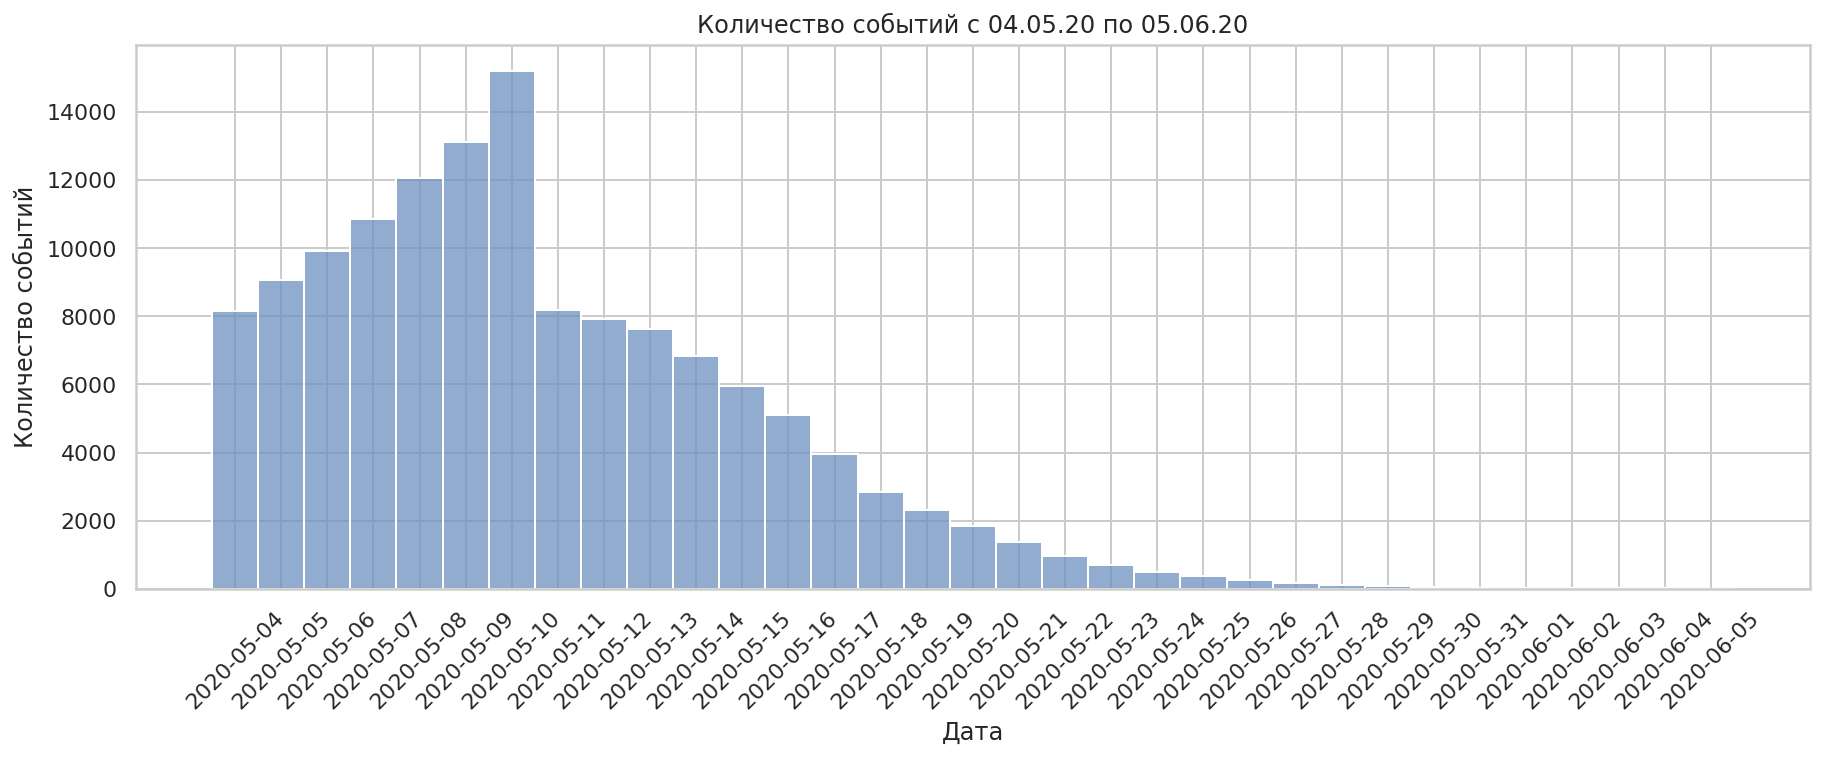

In [19]:
plt.figure(figsize=(15,5))
sns.histplot(x="event_dt", data=events)
plt.title('Количество событий с 04.05.20 по 05.06.20')
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.xticks(rotation=45)
plt.show()

* Активность плавно растет со старта изучаемого периода и достигает пика 10 Мая (13 000 событий в сутки) 
* С 11 Мая активность резко падает до 8 000 событий в сутки и плавно к 30 Мая скатывается до нуля
* Стоит учитывать, что период, выбранный для исследования, частично попадает на Майские празднийи и может искажать реальную картину

Посмотрим максимальное количество пользователей, посетивших приложение:

In [20]:
user_totals = events.groupby('event_dt', as_index=False)['user_id'].nunique()
user_totals = user_totals.rename(columns={'user_id':'users_per_day'})

fig = px.bar(user_totals, y='users_per_day', x='event_dt', text='users_per_day')
fig.update_layout(title='Количество пользователей в день, за период с 04.05.2020 по 05.06.2020',
                   xaxis_title='Дата',
                   yaxis_title='Количество пользователей')
fig.show() 

Картина по количеству пользователей за каждый день исследования похожа на количество совершаемых событий, а именно:
* Количество пользователей плавно растет со старта изучаемого периода и достигает пика 10 Мая (9 219 плоьзователей в сутки) 
* С 11 Мая количество пользователей резко падает до 5 995 пользователей в сутки и плавно к 30 Мая скатывается до нуля

Посмотрим долю событий и типа построек в разрезе всех событий

In [21]:
events_total = events.groupby('event', as_index=False)['user_id'].count()
events_total = events_total.rename(columns={'user_id':'total'})

buildings_total = events.groupby('building_type', as_index=False)['user_id'].count()
buildings_total = buildings_total.rename(columns={'user_id':'total'})

In [22]:
def graph (df1, label1, title1, df2, label2, title2):
    plt.subplot(1, 2, 1)
    df1.plot(kind='pie', figsize=(15,5),autopct='%1.2f%%', labels= label1,
                                 legend=False, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True, 
                                 colors=sns.color_palette("vlag"),
                                )
    plt.title(title1)
    plt.subplot(1, 2, 2)
    df2.plot(kind='pie', figsize=(15,5),autopct='%1.2f%%', labels= label2,  
                                 legend=False, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True, 
                                 colors=sns.color_palette("vlag"),
                                )
    plt.title(title2)

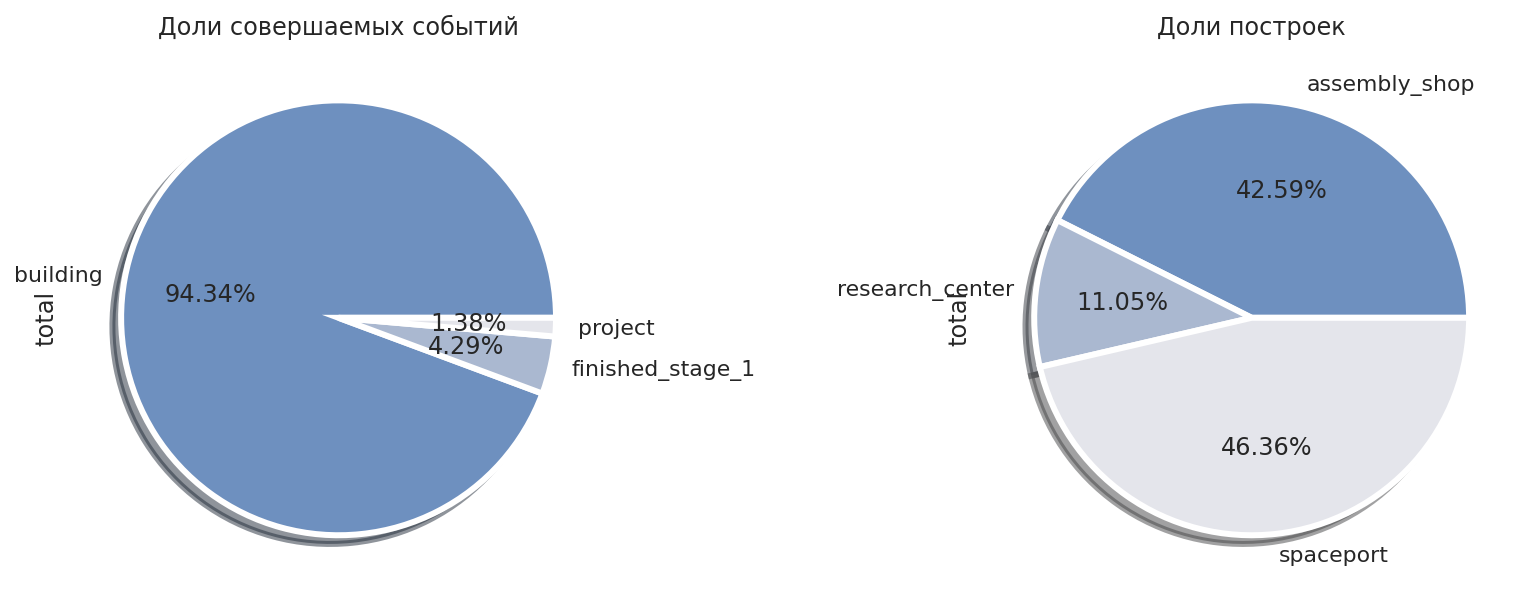

In [23]:
graph (events_total['total'], events_total['event'], 'Доли совершаемых событий',
           buildings_total['total'], buildings_total['building_type'], 'Доли построек')

* Подовляющее большинство событий приходится на тип building (94,34%)
* Среди общего распределения событий только 4,29% являются завершением первого уровня, а 1,38% проекта
* Среди построек чаще всего сооружают spaceport (43,74%) и assembly_shop(40,18%). 
* Общая доля событий без построек составляет 5,66%.   

Посмотрим на распределение событий по дням

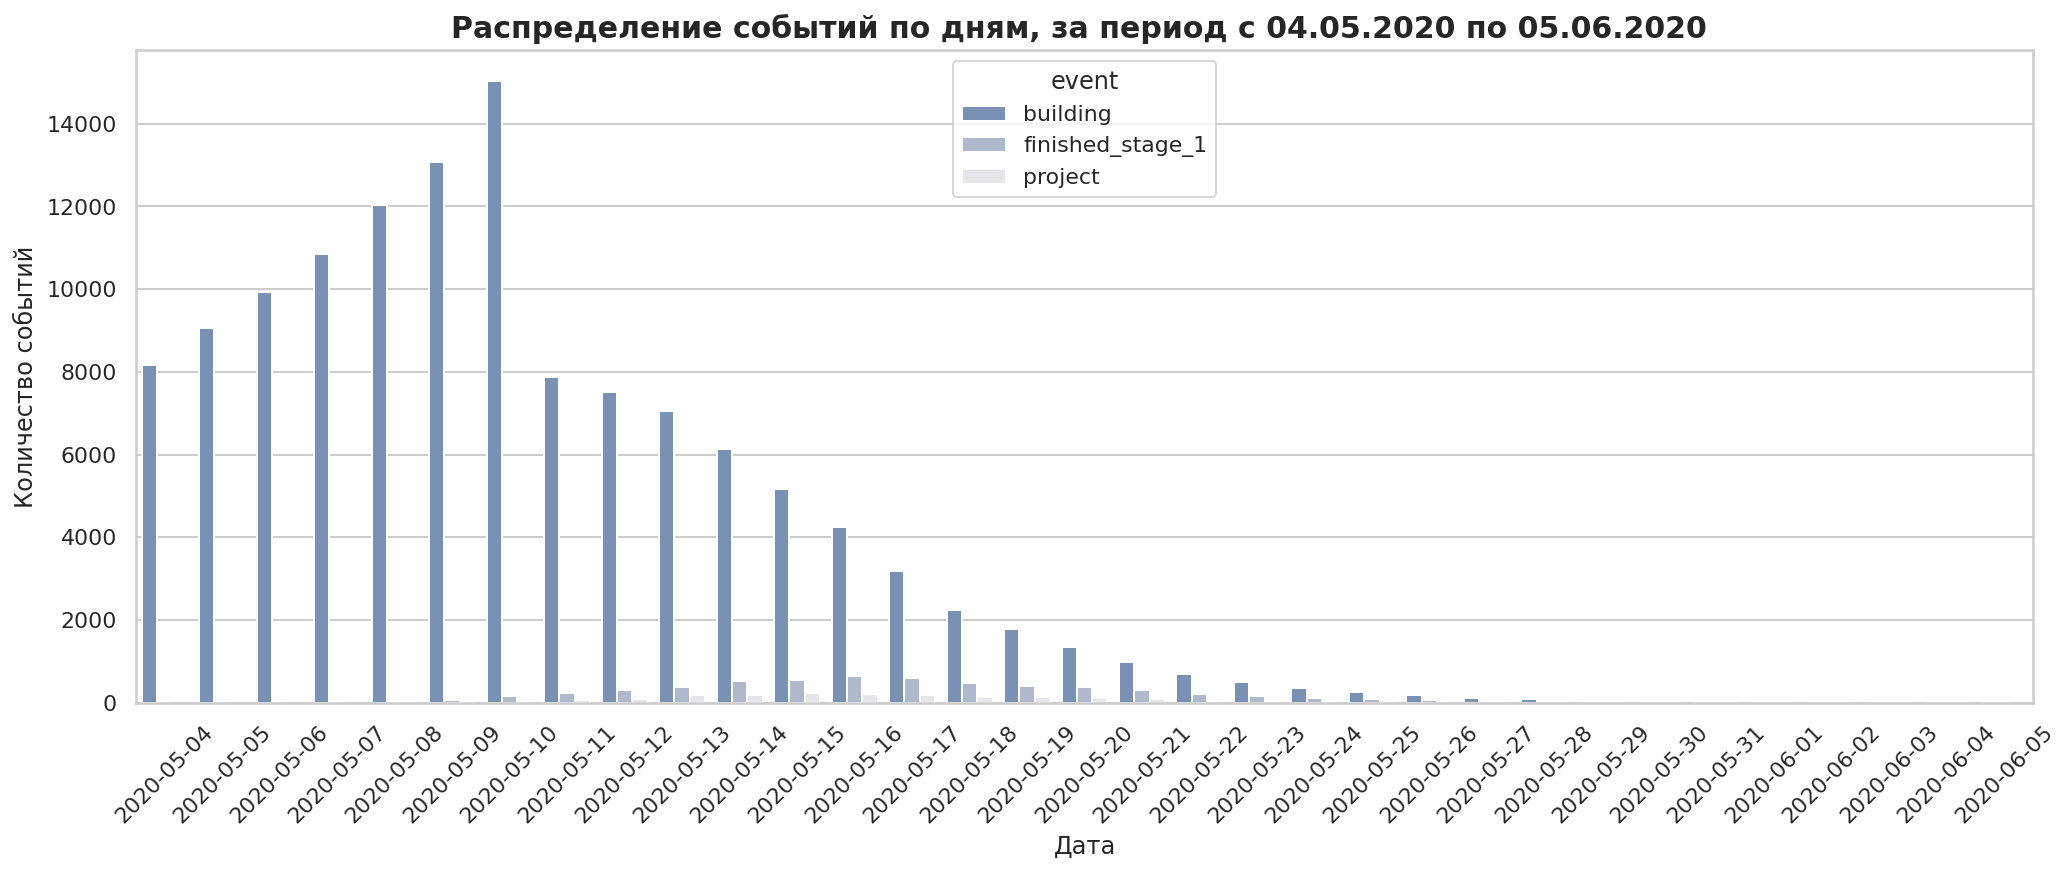

In [24]:
events_per_day = events.groupby(['event_dt', 'event'], \
                        as_index = False)[['user_id']].count()

plt.figure(figsize=(17,6))
sns.barplot(x="event_dt", y="user_id", data=events_per_day, ci=None, hue='event')
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.title('Распределение событий по дням, за период с 04.05.2020 по 05.06.2020 ', fontsize=15, fontweight='bold');
plt.show()

В разрезе событий график похож на общий график количества событий. Для начала посмотрим график распределения построек по дням, а позже вернемся к детализации событий

Text(0.5, 1.0, 'Распределение построения зданий по дням, за период с 04.05.2020 по 05.06.2020')

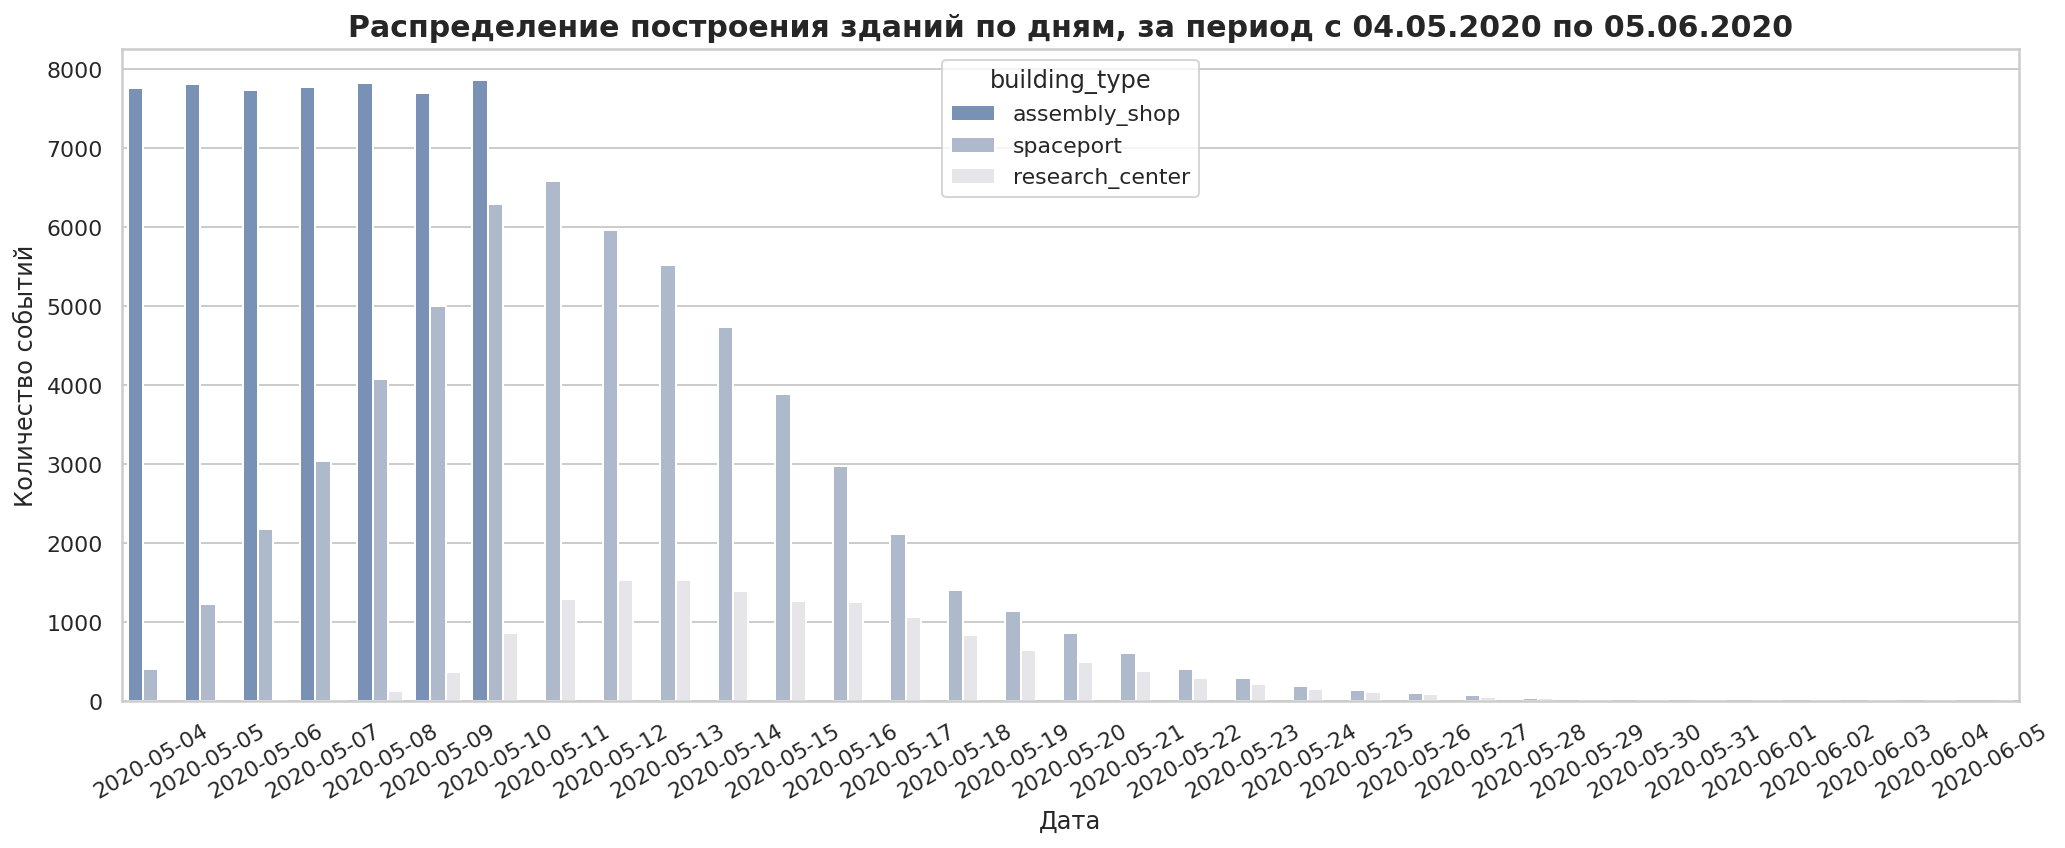

In [25]:
buildings_per_day = events.groupby(['event_dt', 'building_type'], \
                        as_index = False)[['user_id']].count()

plt.figure(figsize=(17,6))
sns.barplot(x="event_dt", y="user_id", data=buildings_per_day, ci=None, hue='building_type')
plt.xticks(rotation=30)
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.title('Распределение построения зданий по дням, за период с 04.05.2020 по 05.06.2020',
          fontsize=15, fontweight='bold')

Вот и причина резкого роста активности пользователей, и резкого её же  сокращения. С первого дня исследования по 10 мая встречается анамально высокий рост построек assemly_shop. С 11 мая строительство такого типа полностью прекратилось. Из остальных наблюдений:
* Здания типа spaceport начинают строить уже в первый день игры
* Первые здания типа research_center строят на 4й день игры (7 мая)
* Первые события, с возможностью перехода на второй уровень (other) происходят на 5й день игры (8 мая)


посмотрим детальней разбивку по постройкам зданий типа assembly_shop в разбивке когорт по дням

In [26]:
first_int = actions.copy()
first_int = first_int.groupby('user_id', as_index=False)['event_dt'].min()

In [27]:
chore = first_int.copy()
chore['event_dt'] = chore['event_dt'].apply(lambda x: x.strftime('%Y-%m-%d'))
chore = chore.rename(columns={'event_dt':'chore'})

chore_events = pd.merge(events, chore, on='user_id', how='outer').reset_index(drop=False)

In [28]:
shop = chore_events.query('building_type == "assembly_shop"')
shop = shop.groupby(['chore', 'event_dt'], as_index=False)['user_id'].count()

fig = px.bar(shop, y='user_id', x='event_dt',color='chore', text='user_id')
fig.update_layout(title='Количество зданий типа assembly_shop за изучаемый период',
                   xaxis_title='Дата',
                   yaxis_title='Количество пользователей')
fig.show()

Показатели колябляться от 7698 по 7869, с учетом того что одновремено в игре находилось от 5860 по 9219 пользователей. В каждой кагорте наблюдатся тенденция, в которой после первого игрового дня общее количество строений типа assembly_shop сокращается в более чем два-три раза и сохраняется на этом уровне. 

Вернемся к общеми разрезу по событиям. Уберем из разреза самое часто встречающееся событие building и посмотрим распределение по датом среди событий finished_stage_1 и project

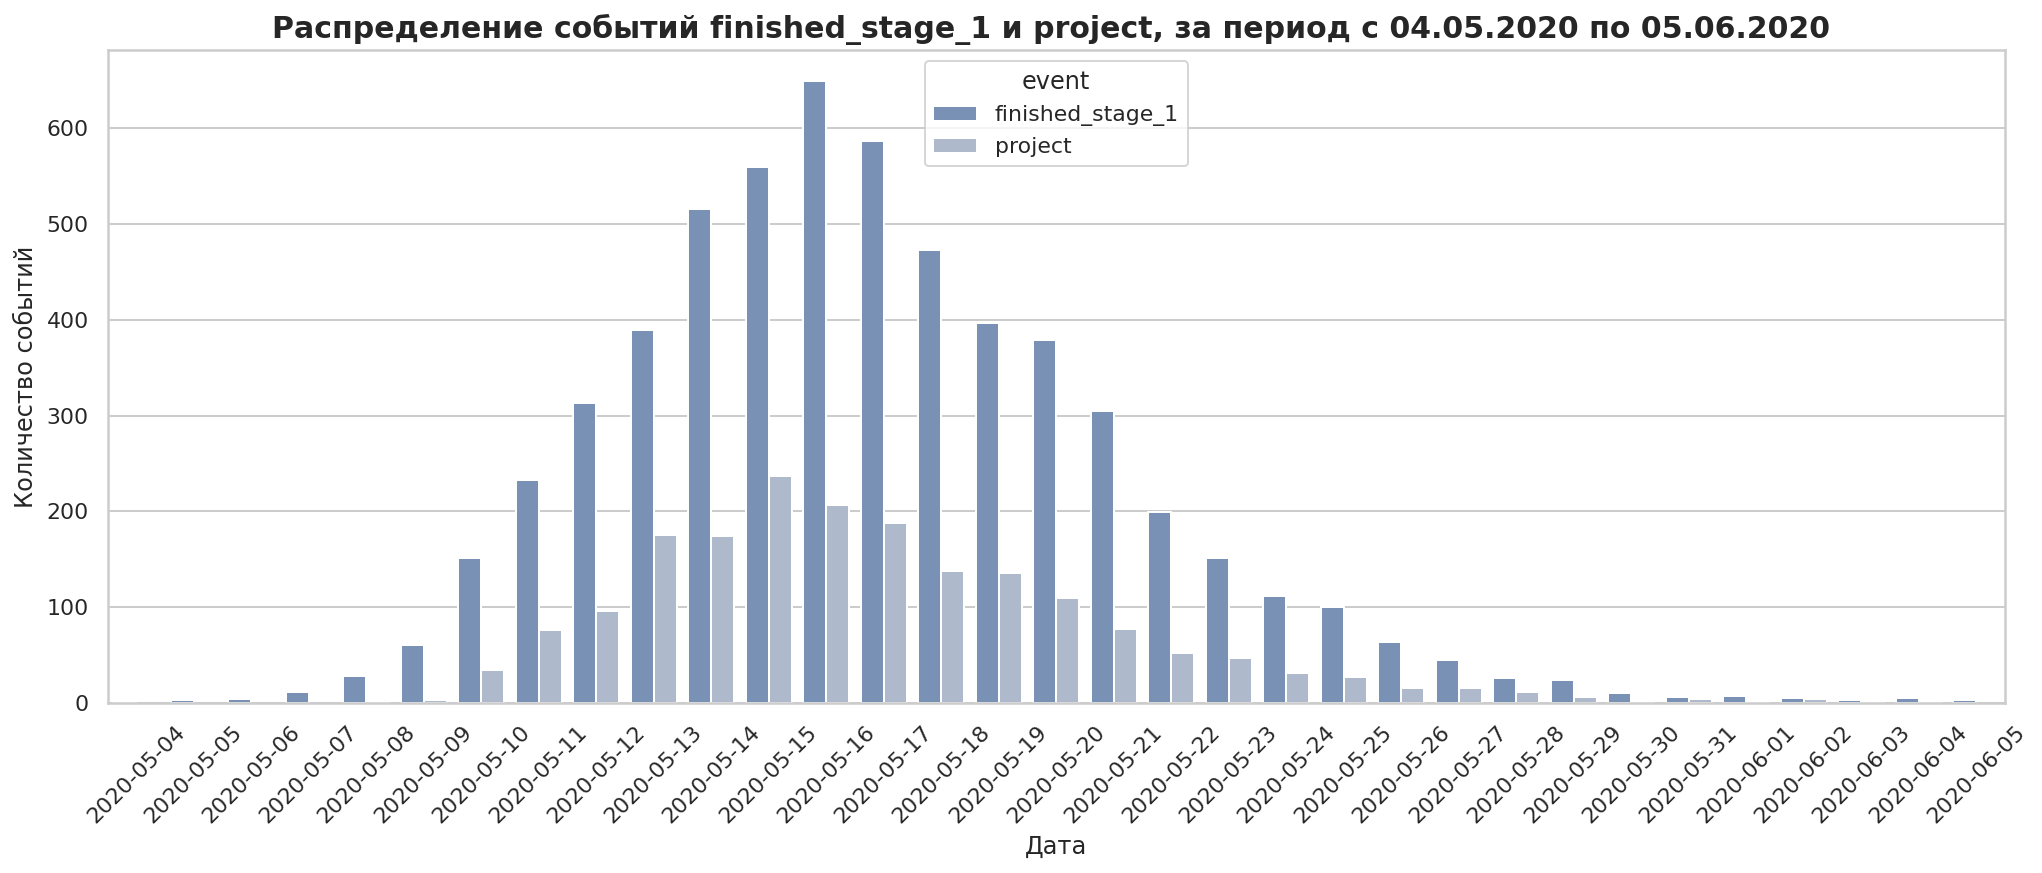

Количество пользователей, завершивших первый уровень: 5817
Количество пользователей, завершивших проект: 1866


In [29]:
fp_events = events_per_day.query('event != "building"')

plt.figure(figsize=(17,6))
sns.barplot(x="event_dt", y="user_id", data=fp_events, ci=None, hue='event')
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.title('Распределение событий finished_stage_1 и project, за период с 04.05.2020 по 05.06.2020 '
          , fontsize=15, fontweight='bold');
plt.show()

print('Количество пользователей, завершивших первый уровень:', 
      events.query('event == "finished_stage_1"')['user_id'].nunique())

print('Количество пользователей, завершивших проект:', 
      events.query('event == "project"')['user_id'].nunique())

* График распредения выглядит нормально по кадому из событий, с плавным подъемом и спуском 
* Наблюдачется разница практически в два раза между количеством событий finished_stage_1 и project

По условиям заданий завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

Получается пользователи, прошедшие событие project получили шанс пройти на втрой уровень в услувиях системы pve (Player versus environment / игрок против окружения). А разница игроков, не прошедших событие project, но получившие шанс  пройти на втрой уровень в услувиях системы pvp (Player versus player / игрок против игрока). Поскольку исполнение проекта выделено в отдельную колонку, ее можно использовать, чтобы выделить пользователям по отдельным тактикам и сделать два отдельных датасета: для пользователей с тактиков pvp и  для пользователей с такстикой pve.

Проверим какие сооружения чаще всего строили пользователи, имеющие шанс перейти на следующий уровень

In [30]:
second_level = events.query('event == "finished_stage_1"')
second_level_users = events.query('user_id in @second_level["user_id"]')

second = second_level_users.groupby('building_type', as_index=False)['user_id'].count()

fig = go.Figure(data=[go.Pie(labels=second['building_type'], values=second['user_id'], hole=.8)])

fig.update_layout(
    annotations=[dict(text='Общее количество  <br> строений пользователей <br> закончивших <br> первый уровень',
                      x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()


* Пользователи, завершившие первый уровень, чаще всего строили космопорт (27 920 раз)
* Реже всего победители строили исследовательский центр (7452 постройки)

По условиям заданий завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

Получается пользователи, прошедшие событие project получили шанс пройти на втрой уровень в услувиях системы pve (Player versus environment / игрок против окружения). А разница игроков, не прошедших событие project, но получившие шанс  пройти на втрой уровень в услувиях системы pvp (Player versus player / игрок против игрока). Поскольку исполнение проекта выделено в отдельную колонку, ее можно использовать, чтобы выделить пользователям по отдельным тактикам и сделать два отдельных датасета: для пользователей с тактикой pvp и для пользователей с такстикой pve среди тех, которые завершили первый уровень

In [31]:
environment = second_level_users.query('SAO == True')
pve = events.query('user_id in @environment["user_id"]')
pve['tactic'] = 'pve'
pve.head()

/tmp/ipykernel_193/3684430935.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



event_dt     event  building_type                               user_id  \
1   2020-05-04  building  assembly_shop  c07b1c10-f477-44dc-81dc-ec82254b1347   
8   2020-05-04  building  assembly_shop  65a92713-5969-48b1-8945-bfefa5063887   
9   2020-05-04  building  assembly_shop  fa352362-d258-472c-b295-2796ccc39fa3   
13  2020-05-04  building  assembly_shop  7b3b6554-7949-4065-9808-d6c79bdc2f58   
20  2020-05-04  building  assembly_shop  b374304d-2f74-4cc1-a4e2-500da44a06c7   

      SAO tactic  
1   False    pve  
8   False    pve  
9   False    pve  
13  False    pve  
20  False    pve

In [32]:
pvp = second_level_users.query('user_id not in @environment["user_id"]')
pvp['tactic'] = 'pvp'
pvp.head()

/tmp/ipykernel_193/3328933810.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



event_dt     event  building_type                               user_id  \
2   2020-05-04  building  assembly_shop  6edd42cc-e753-4ff6-a947-2107cd560710   
4   2020-05-04  building  assembly_shop  cdc6bb92-0ccb-4490-9866-ef142f09139d   
6   2020-05-04  building  assembly_shop  4fe0f101-694b-4e31-9740-d1d87f7208ea   
11  2020-05-04  building  assembly_shop  9c200ece-3b74-44c4-8a3f-260f2486c5d7   
15  2020-05-04  building  assembly_shop  02bf92c2-17a0-4156-be88-2054fb6b7421   

      SAO tactic  
2   False    pvp  
4   False    pvp  
6   False    pvp  
11  False    pvp  
15  False    pvp

Эти отдельные датафреймы пригодятся нам при проверке гипотез. Общие тенденции пользовательского поведения понятны, с частными разберемся в другой части исследования. 

## Оценка расходов и стоимости привлечения пользователя по дням <a class="anchor" id="costs"></a>

Расходы по привлечению пользователей по дням расположены в датасете ad_cosct.csv. Посмотрим каналы трафика, дату старта и завершения и самые дорогие и дешевые дни 

In [33]:
print ('Всего уникальных источников трафика:', costs['source'].nunique())
print ('Перечень источников трафика:', costs['source'].unique())
print ('Общая стоимость рекламной кампании', int(costs['cost'].sum()))
print ('Медианная стоимость рекламного дня', int(costs['cost'].median()))
print ('Максимальная стоимость рекламного дня', costs['cost'].max())
print ('Минимальная стоимость рекламного дня', costs['cost'].min())
print ('Средняя стоимость одного пользователя',  round(costs['cost'].sum() / len(user), 2))
print ('Дата самого раннего события:', costs['day'].min())
print ('Дата самого позднего события:', costs['day'].max())

Всего уникальных источников трафика: 4
Перечень источников трафика: ['facebook_ads' 'instagram_new_adverts' 'yandex_direct'
 'youtube_channel_reklama']
Общая стоимость рекламной кампании 7603
Медианная стоимость рекламного дня 160
Максимальная стоимость рекламного дня 969.14
Минимальная стоимость рекламного дня 23.31
Средняя стоимость одного пользователя 0.56
Дата самого раннего события: 2020-05-03 00:00:00
Дата самого позднего события: 2020-05-09 00:00:00


### Распределение бюджета на источник <a class="anchor" id="source"></a>

In [34]:
costs_amount = int(costs['cost'].sum())

Посмотрим распределение рекламного бюджета по источникам и дням 

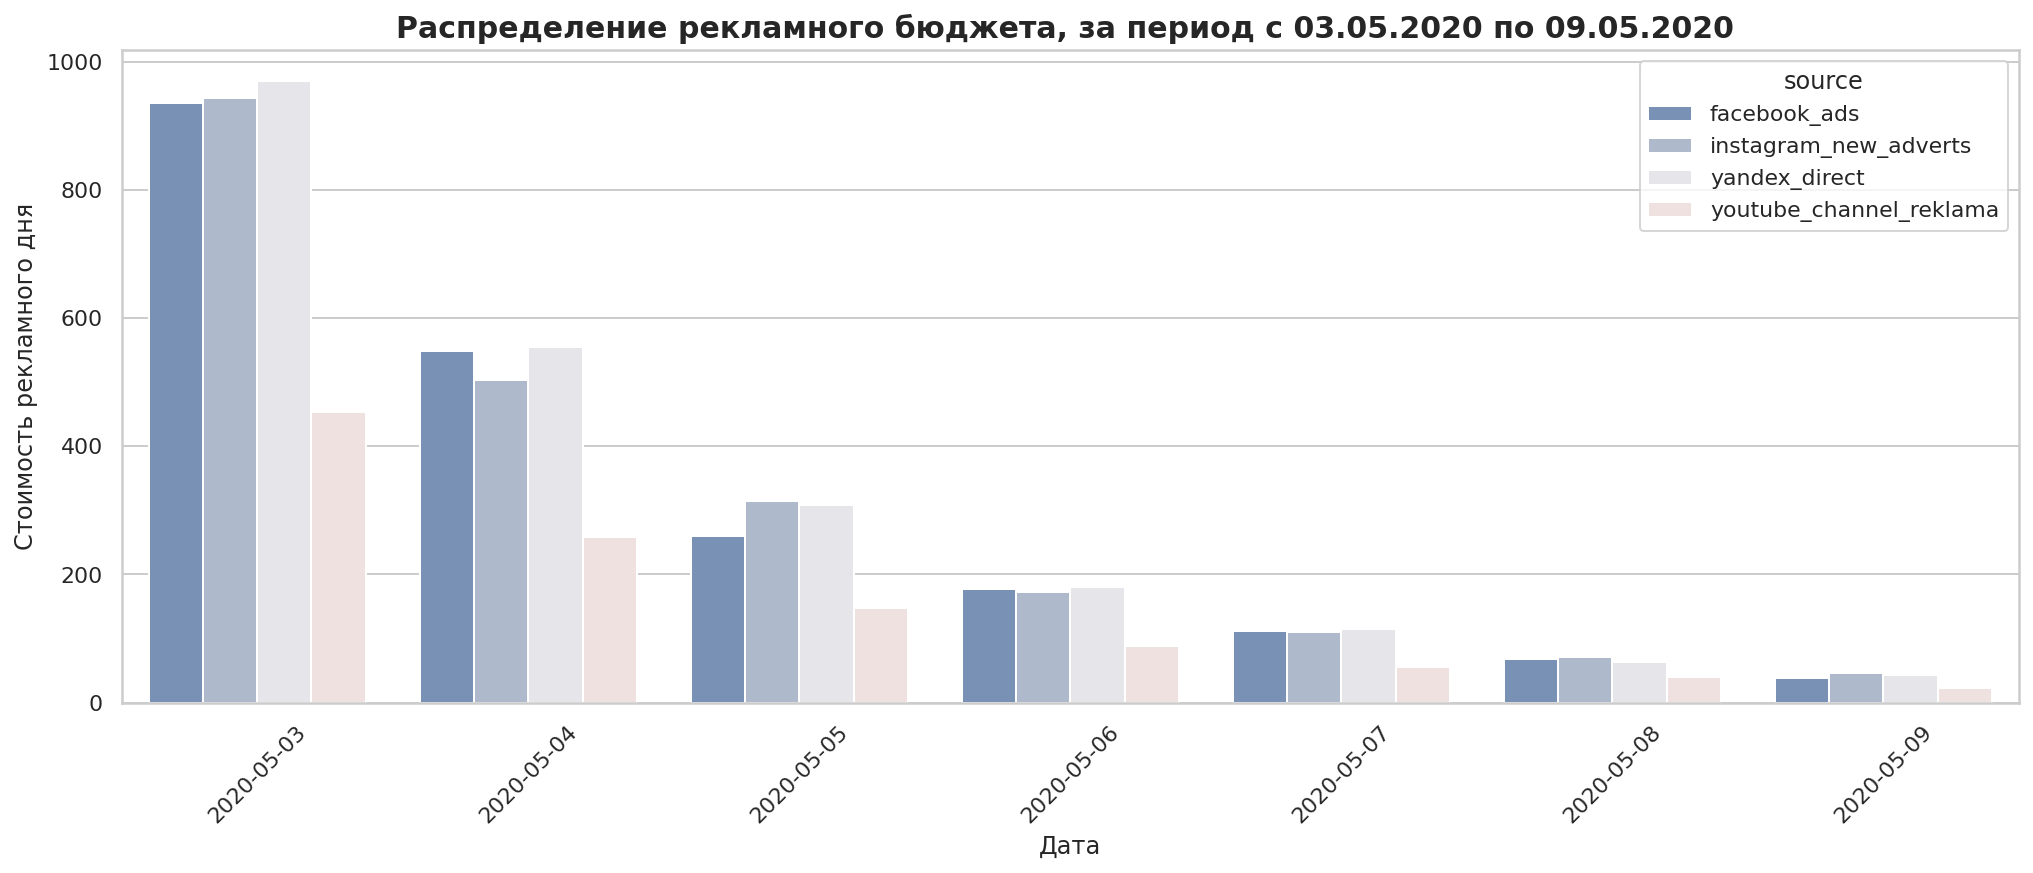

In [35]:
costs['day'] = costs['day'].apply(lambda x: x.strftime('%Y-%m-%d'))

plt.figure(figsize=(17,6))
sns.barplot(x="day", y="cost", data=costs, ci=None, hue='source')
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Стоимость рекламного дня")
plt.title('Распределение рекламного бюджета, за период с 03.05.2020 по 09.05.2020 '
          , fontsize=15, fontweight='bold');
plt.show()

* Больше всего денег ушло на привлечение пользователей в первый день рекламной кампании, и дальше плавно уменьшался 
* Распределение бюджета на 'facebook_ads', 'instagram_new_adverts' и 'yandex_direct' примерно пропорциональное
* На 'youtube_channel_reklama' было выделено значительно меньше средств, на протяжении всего срока кампании

Так же в нашем распоряжении есть датафрейм user_source.csv, ответственный за источники привлечения пользователей. Посмотрим долю каналов на количество привлеченных пользователей

In [36]:
source = user.groupby('source', as_index=False)['user_id'].count()

fig = go.Figure(data=[go.Pie(labels=source['source'], values=source['user_id'], hole=.8)])

fig.update_layout(
    annotations=[dict(text='Доля рекламных <br> каналов по кол-ву <br> привлеченных <br> пользователей',
                      x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

* Больше всего пользователей пришло с yandex_direct (4 817 новых пользователей)
* На втором месте instagram_new_adverts (3 347 новых пользователей)
* В районе 20% по общему притоку разделили facebook_ads (2 726) и youtube_channel_reklama (2 686)

Чтобы посмотреть распределение пользователей по дня, сократим датасет actions до первого событие совершенного уникальным пользователем и объеденим таблицу с каналами привлечения

### Распределение бюджета на пользователя <a class="anchor" id="user"></a>

In [37]:
merged = pd.merge(first_int, user, on='user_id', how='outer')
merged.head()

user_id            event_dt  \
0  0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06 01:07:37   
1  00151b4f-ba38-44a8-a650-d7cf130a0105 2020-05-06 03:09:12   
2  001aaea6-3d14-43f1-8ca8-7f48820f17aa 2020-05-05 18:08:52   
3  001d39dc-366c-4021-9604-6a3b9ff01e25 2020-05-05 21:02:05   
4  002f508f-67b6-479f-814b-b05f00d4e995 2020-05-05 13:49:58   

                    source  
0             facebook_ads  
1            yandex_direct  
2  youtube_channel_reklama  
3    instagram_new_adverts  
4             facebook_ads

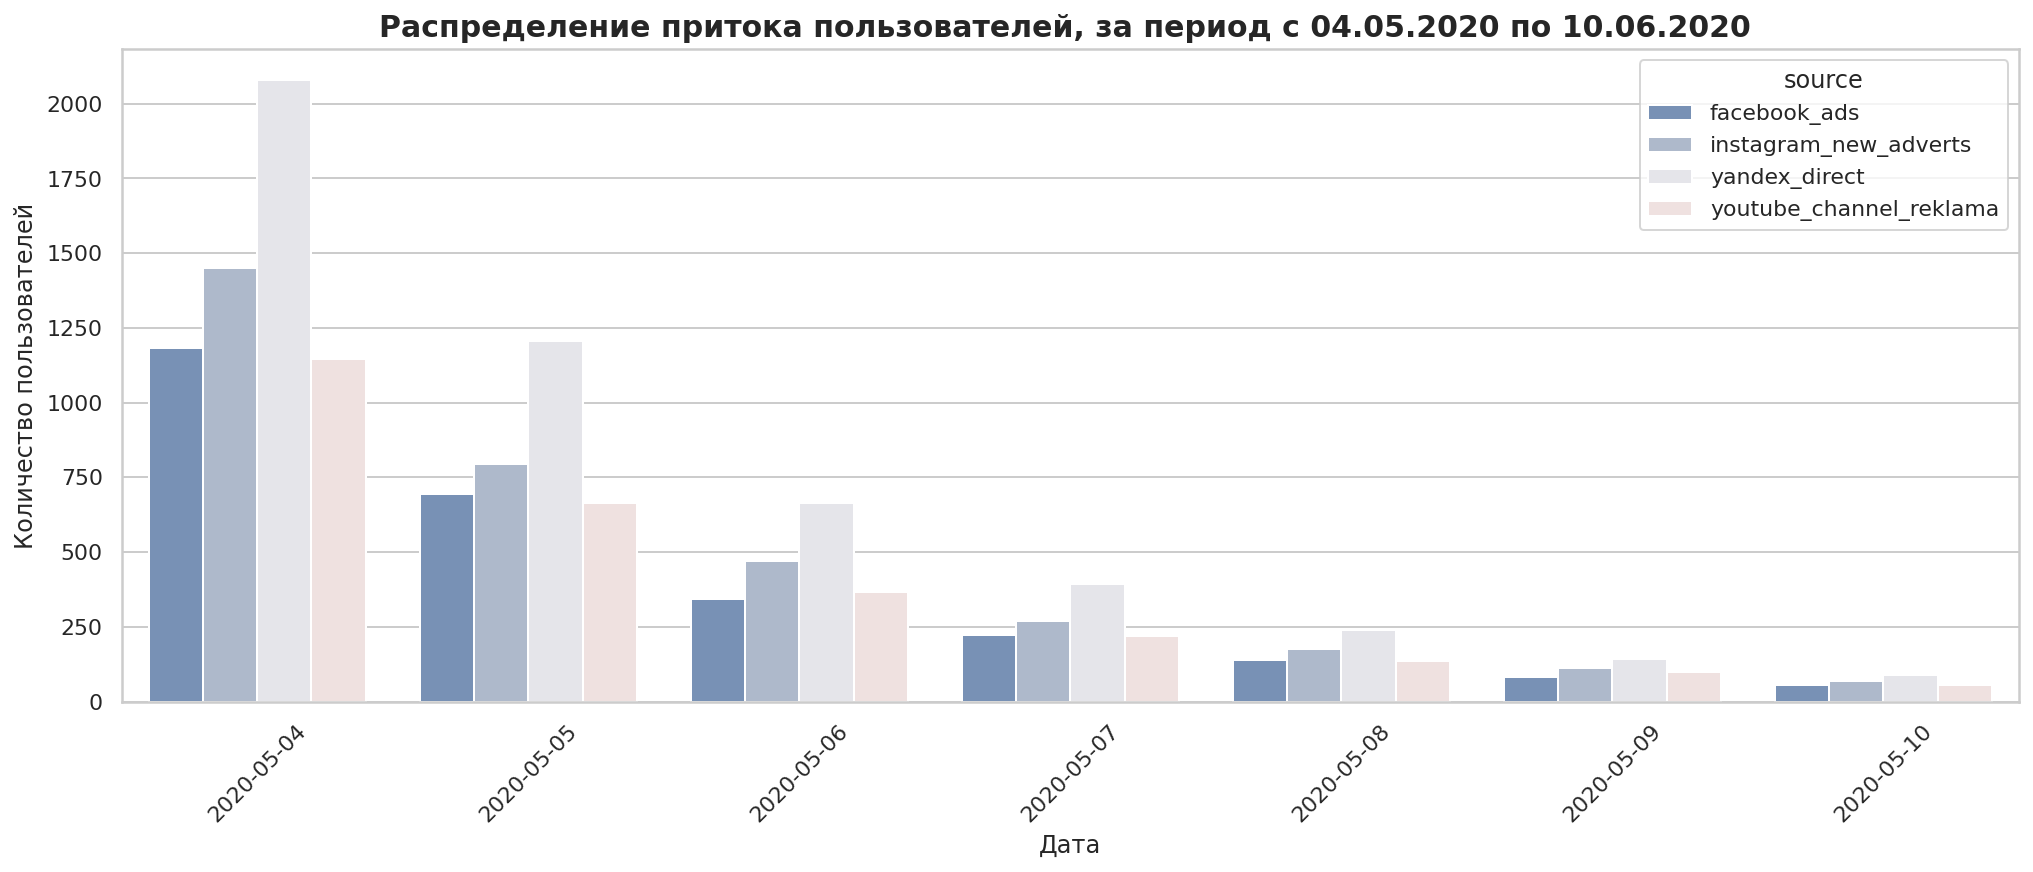

In [38]:
merged['event_dt'] = merged['event_dt'].apply(lambda x: x.strftime('%Y-%m-%d'))

users_per_source = merged.groupby(['event_dt', 'source'], \
                        as_index = False)[['user_id']].count()

plt.figure(figsize=(17,6))
sns.barplot(x="event_dt", y="user_id", data=users_per_source, ci=None, hue='source')
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Количество пользователей")
plt.title('Распределение притока пользователей, за период с 04.05.2020 по 10.06.2020 ', fontsize=15, fontweight='bold');
plt.show()

* Наибольшее кол-во пользователей стабильно приходят через yandex_direct 
* facebook_ads приносит столько же пользователей, сколько youtube_channel_reklama

Посмотрим распределение затрат по стоимости рекламы на количество привлеченных ползователей по дням и увидим, какие источники рекламы выгоднее всего в соотвеношении цена/кол-во пользователей

In [39]:
users_per_source = users_per_source.sort_values(['source', 'event_dt']).reset_index(drop=True)

extracted_col = costs['cost']
merged_cost = pd.concat([users_per_source, extracted_col], axis=1)
merged_cost['cac'] = merged_cost['cost'] / merged_cost['user_id']
merged_cost.head()

event_dt        source  user_id    cost       cac
0  2020-05-04  facebook_ads     1184  935.88  0.790439
1  2020-05-05  facebook_ads      694  548.35  0.790130
2  2020-05-06  facebook_ads      345  260.19  0.754174
3  2020-05-07  facebook_ads      224  177.98  0.794554
4  2020-05-08  facebook_ads      139  111.77  0.804101

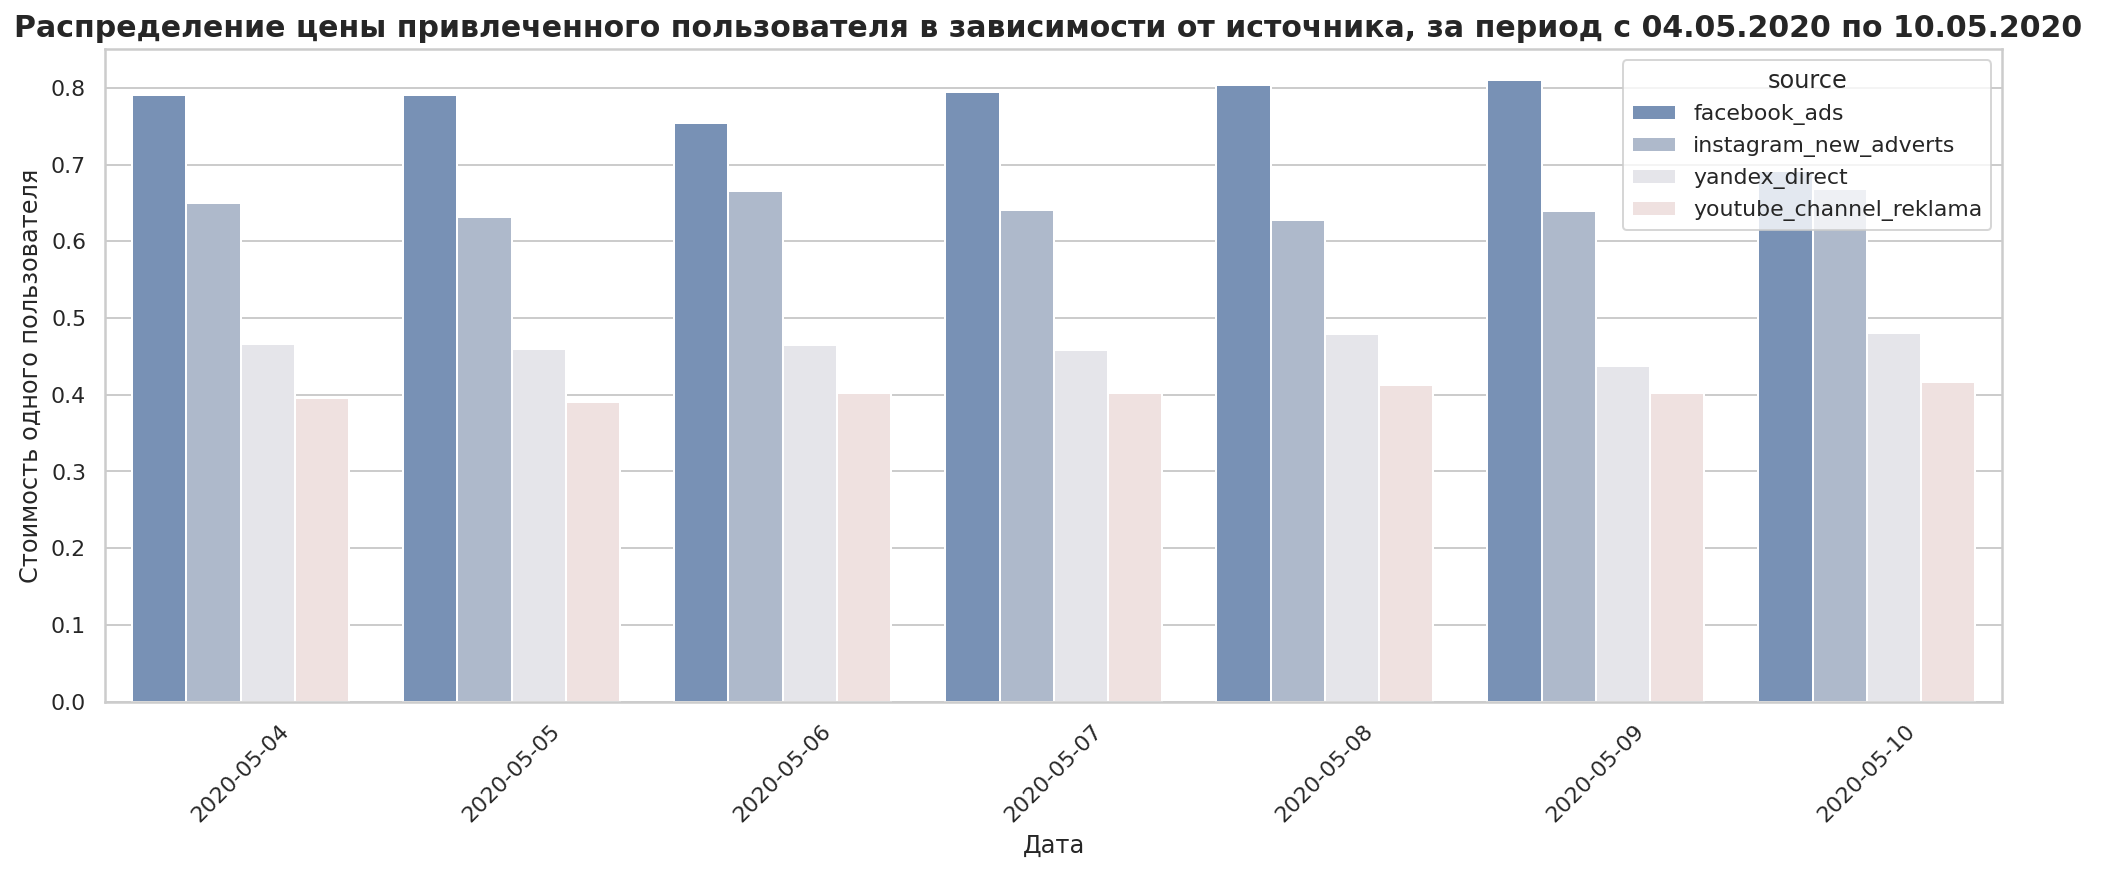

In [40]:
plt.figure(figsize=(17,6))
sns.barplot(x="event_dt", y="cac", data=merged_cost, ci=None, hue='source')
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Стоимость одного пользователя")
plt.title('Распределение цены привлеченного пользователя в зависимости от источника, за период с 04.05.2020 по 10.05.2020 ',
          fontsize=15, fontweight='bold');
plt.show()

* В целом САС по дням выглядит одинаково, без резких скачков. 
* Самым дорогим каналом привлечения стал facebook_ads
* Дешевле всех обошлись пользователи, пришедшие через yandex_direct и youtube_channel_reklama

### Выводы по расходам <a class="anchor" id="cost_explained"></a>

* Распределение бюджета на 'facebook_ads', 'instagram_new_adverts' и 'yandex_direct' примерно пропорциональное 
* Больше всего пользователей пришло с yandex_direct (4 817 новых пользователей)
* facebook_ads приносит столько же пользователей, сколько youtube_channel_reklama 
* Самым дорогим каналом привлечения стал facebook_ads
* Дешевле всех обошлись пользователи, пришедшие через yandex_direct и youtube_channel_reklama

## Оценка текущей модели монетизации <a class="anchor" id="monetisation"></a>

Известно, что рекламу показывают при типе события building и прибыль с показа одной рекламы составляет 0,07 у.е. Ранее мы посчитали, что общие затраты на рекламную кампанию составили 7 603 у.е. Создадим таблицу с распределением прибыли на день и посмотрим динамику по дням

In [41]:
profit_per_event = 0.07

profit_source = events.query('event == "building"')

profit = profit_source.groupby(['event_dt'], \
                        as_index = False)[['event']].count()
profit['profit'] = profit['event'] * profit_per_event
profit['day_by_day'] = profit['profit'].cumsum()

fig = px.line(profit, x='event_dt', y="day_by_day", markers=True)
fig.update_layout(title='Кумулятивная прибыль по дням, за период с 04.05.2020 по 05.06.2020',
                   xaxis_title='Дата',
                   yaxis_title='Количество у.е.')
fig.show()
print ('Суммарная выручка за исследуемый период составила',profit['profit'].sum().round(decimals = 2))
print ('Суммарная выручка за первую неделю', profit['profit'].loc[0:7].sum().round(decimals = 2))
print ('Суммарная выручка за первые две недели', profit['profit'].loc[0:14].sum().round(decimals = 2))
print ('Прибыль за исследуемый период с учетом расходов составила', profit['profit'].sum().round(decimals = 2) - costs_amount)

Суммарная выручка за исследуемый период составила 8956.92
Суммарная выручка за первую неделю 6018.88
Суммарная выручка за первые две недели 8505.49
Прибыль за исследуемый период с учетом расходов составила 1353.92


Выводы по графику кумулятивной прибыли:
* Выручка плавно растет со старта изучаемого периода и достигает пика 10 Мая (1 054 у.е.)
* С 11 Мая выручка сбавляет рост и с 24 мая практически не растет 
* За вычетом расходов на привлечение игроков в чистом виде прибыль составляет 1 353,92

Разделим пользователей, приносящих доход на когорты по времени их прихода и посмотрим как распределяется LTV, **держа в уме понимание о том, что с каждым днем приток пользователей был все меньше и меньше.** 

In [42]:
merged_chore = pd.merge(profit_source, chore, on='user_id', how='outer').reset_index(drop=False)
merged_chore = merged_chore.groupby(['chore','event_dt'])[['user_id']].count()
merged_chore['profit_per_day'] = merged_chore['user_id'] * profit_per_event
merged_chore['profit_cumulat'] = merged_chore.groupby('chore')['profit_per_day'].cumsum() 

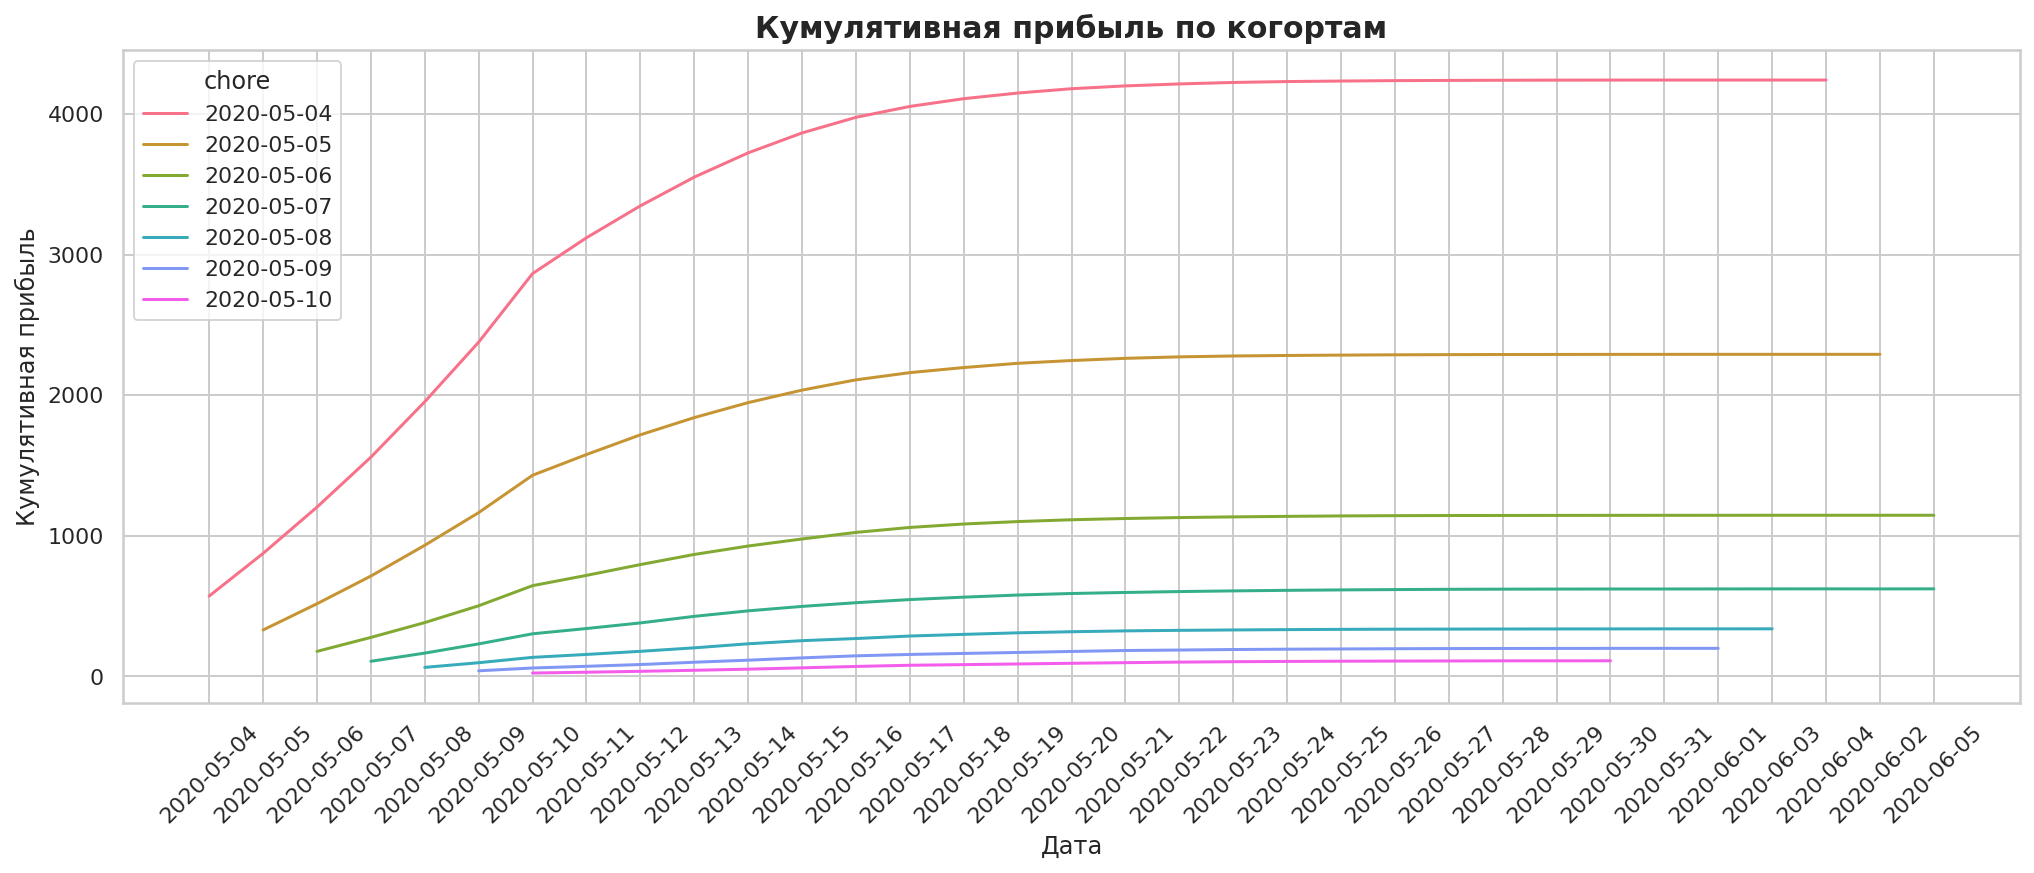

In [43]:
plt.figure(figsize=(17,6))
sns.lineplot(x="event_dt", y="profit_cumulat",
             hue="chore", 
             data=merged_chore)
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Кумулятивная прибыль")
plt.title('Кумулятивная прибыль по когортам', fontsize=15, fontweight='bold');
plt.show()

* Дольше и стабильнее всего прибыль приносили Когорты, приведенные с 4 по 6 мая. Срок активности и прибыльности составляет 1 месяц;
* Когорты, приведенные с 4 по 6 мая приносят наибольшую прибыль с первого по 12 день активности;
* Срок активность пользователей, привлеченных 8-10 мая заметно короче

## Сравнение pvp и pve пользователей <a class="anchor" id="pvp_vs_pve"></a>

Ранее мы разделили весь дата фрейм на два, в соотвествии со стратегией. Посмотрим сколько событий и пользователей вошло в каждый из них

In [44]:
print ('Пользователи, предпочитающие pve стиль игры:', pve['user_id'].nunique())
print ('Всего событий на pve пользователей', len(pve))
print ('Пользователи, предпочитающие pvp стиль игры:', pvp['user_id'].nunique())
print ('Всего событий на pvp пользователей', len(pvp))

Пользователи, предпочитающие pve стиль игры: 1866
Всего событий на pve пользователей 27333
Пользователи, предпочитающие pvp стиль игры: 3951
Всего событий на pvp пользователей 41136


Похоже, большинство игроков не завершили постройку орбитальной станции и в распределение попали как игроки со стилем игры pvp. 

Посмотрим как конкретно распределяются события и постройки для каждого стиля игры:

### Доли событий и типов построек <a class="anchor" id="cut"></a>

In [45]:
events_pve = pve.groupby('event', as_index=False)['user_id'].count()
events_pve = events_pve.rename(columns={'user_id':'total'})

buildings_pve = pve.groupby('building_type', as_index=False)['user_id'].count()
buildings_pve = buildings_pve.rename(columns={'user_id':'total'})

events_pvp = pvp.groupby('event', as_index=False)['user_id'].count()
events_pvp = events_pvp.rename(columns={'user_id':'total'})

buildings_pvp = pvp.groupby('building_type', as_index=False)['user_id'].count()
buildings_pvp = buildings_pvp.rename(columns={'user_id':'total'})

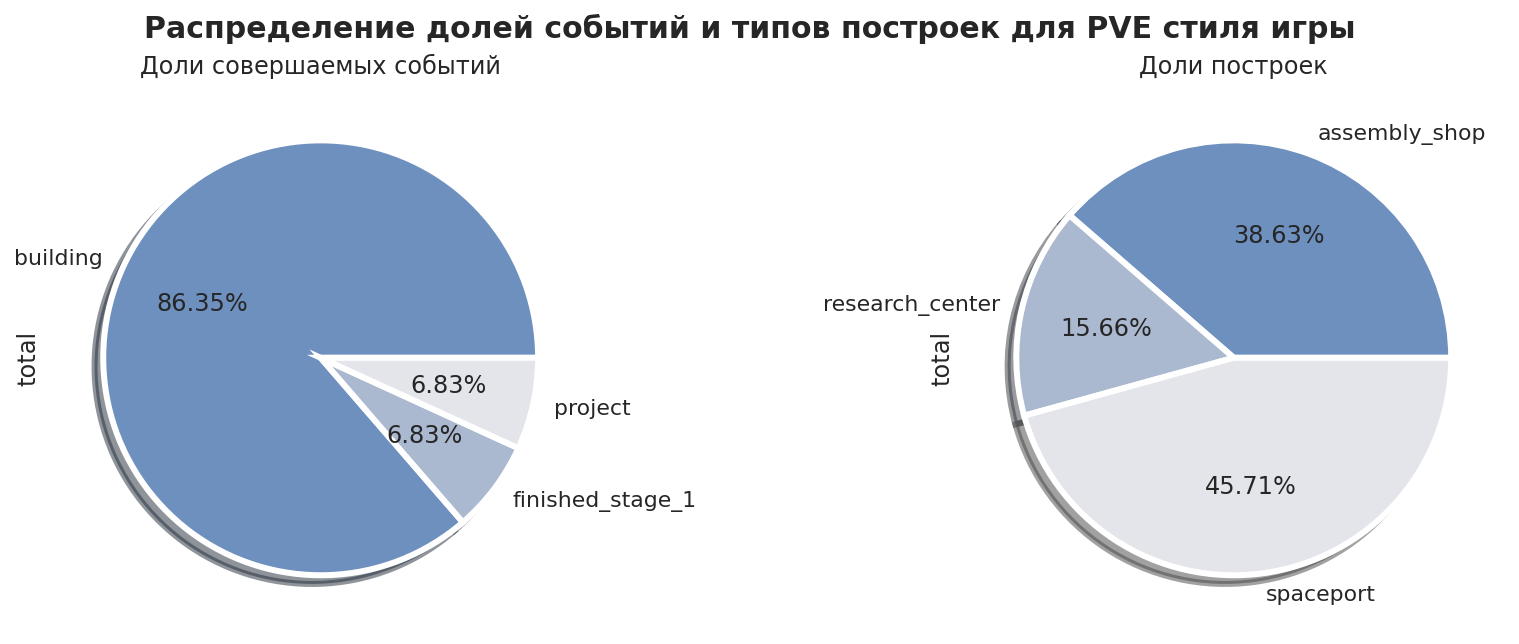

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Распределение долей событий и типов построек для PVE стиля игры', fontsize=15, fontweight='bold');
graph (events_pve['total'], events_pve['event'], 'Доли совершаемых событий',
           buildings_pve['total'], buildings_pve['building_type'], 'Доли построек')

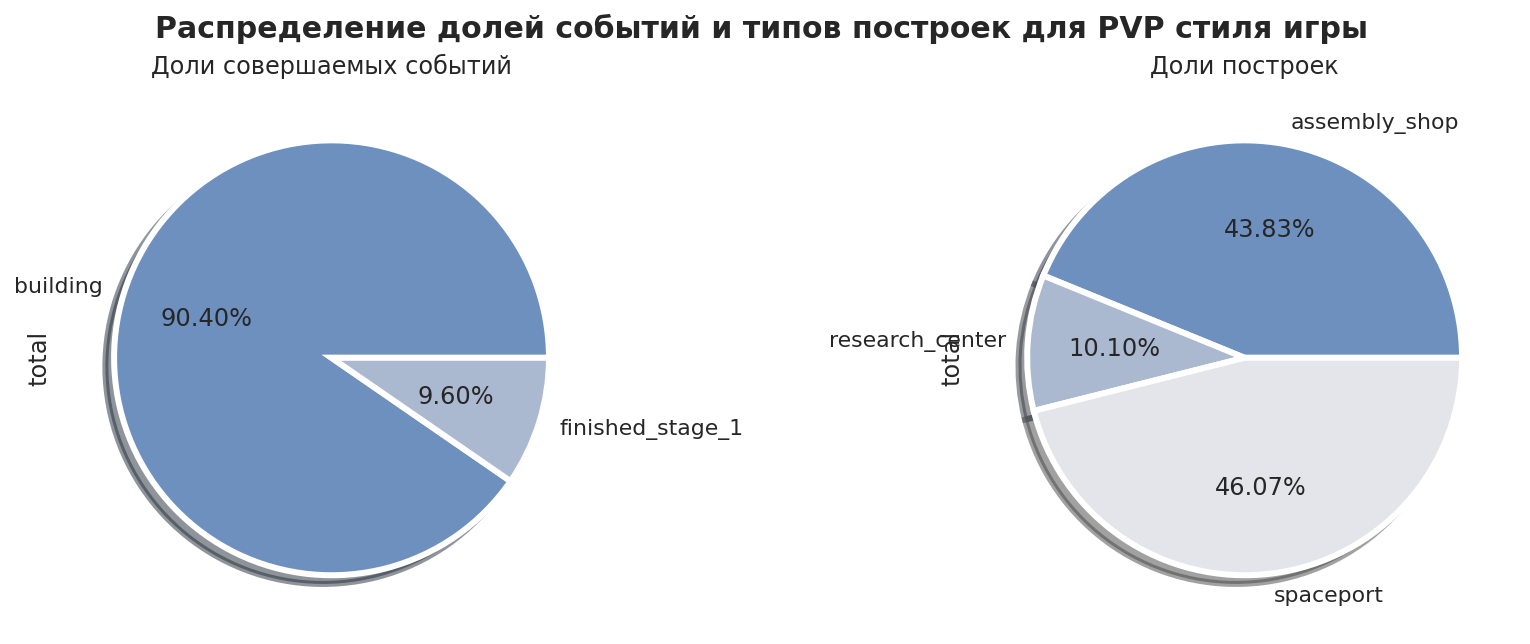

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Распределение долей событий и типов построек для PVP стиля игры', fontsize=15, fontweight='bold');

graph (events_pvp['total'], events_total['event'], 'Доли совершаемых событий', 
       buildings_pvp['total'], buildings_total['building_type'], 'Доли построек')

Сравнивая pve и pvp стили игры можно выделить следующее:

* среди общего количество событий в группе pve 6,83% занимают "завершение уровня", которое совпадает с показателем project. В то время как общий процент событий "завершения" в pvp составляет 9,6%. 
* Доля исследовательских центров у pvp игроков выше (15,66% против 10,10%)
* pvp игроки заметно чаще строят assembly_shop (43,83% против 38,63%)
* pvp и pve с одинаковой частотой строят spaceport (46,07% и 45,71% от пользователей, после разделения по стилям)

Посмотрим на динамику строительства различных объекетов в ретроспектве за исследуемый период 

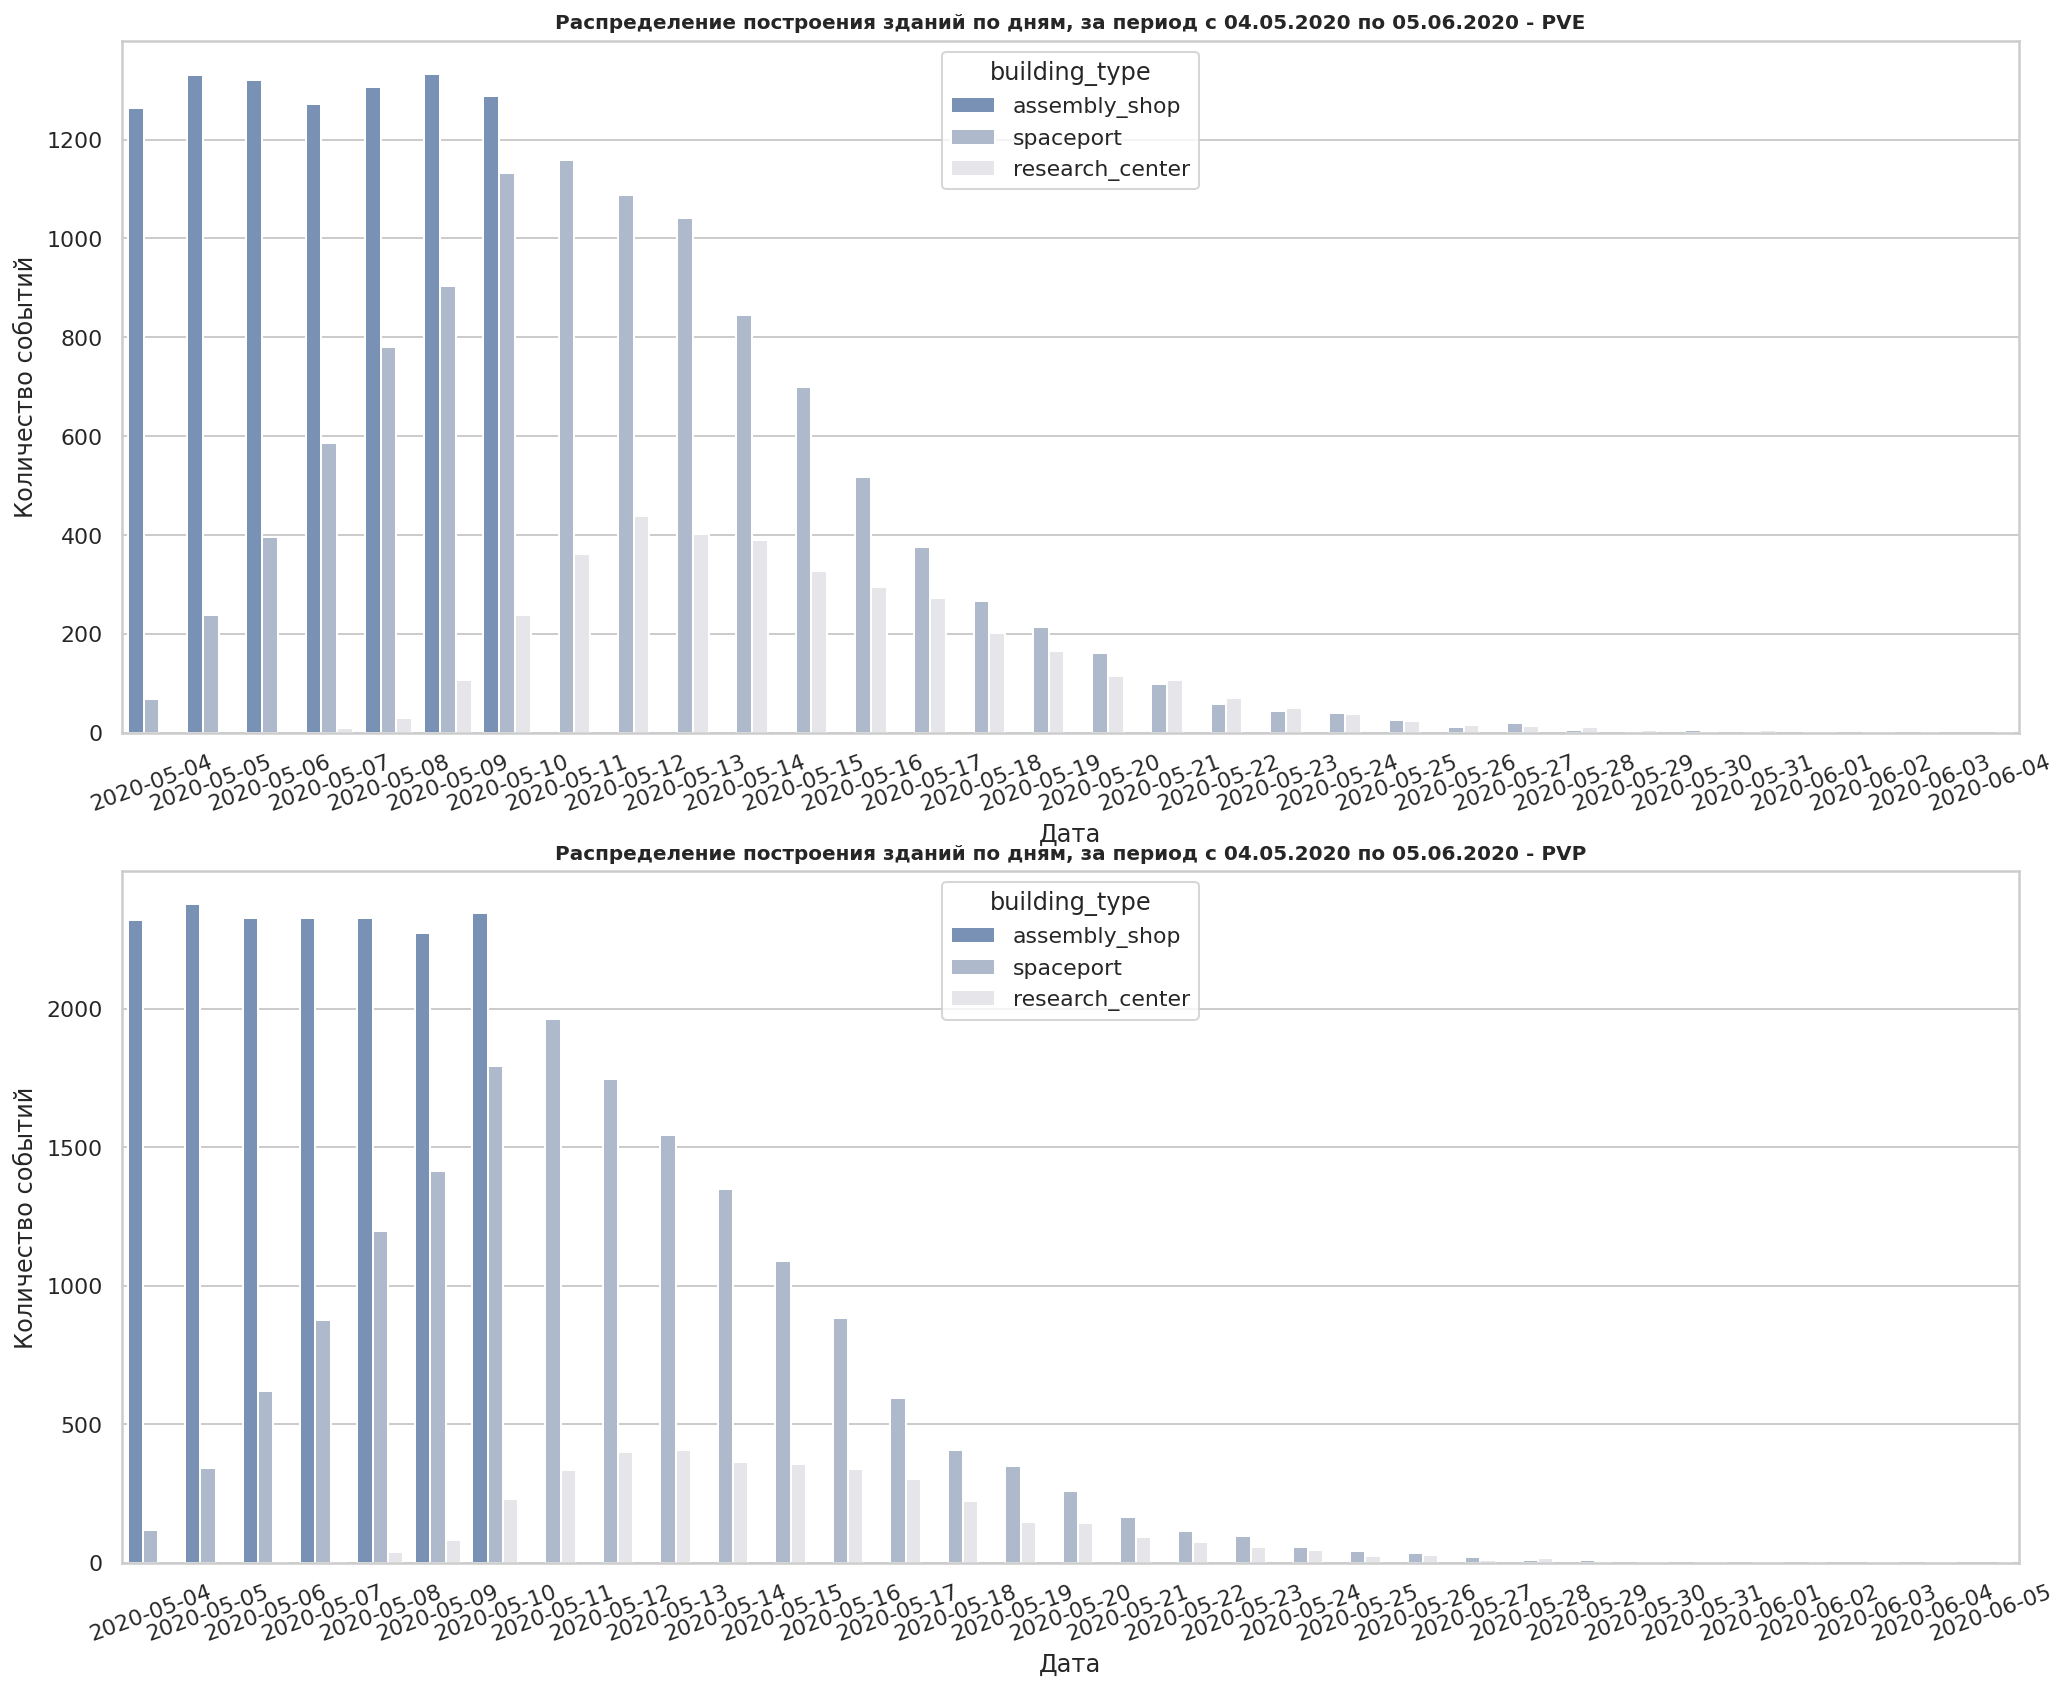

In [48]:
pve_buildings = pve.groupby(['event_dt', 'building_type'], \
                        as_index = False)[['user_id']].count()

pvp_buildings = pvp.groupby(['event_dt', 'building_type'], \
                        as_index = False)[['user_id']].count()

fig, axes = plt.subplots(2, 1, figsize=(17, 14))

plt.subplot(2, 1, 1)
sns.barplot(x="event_dt", y="user_id", data=pve_buildings, ci=None, hue='building_type')
plt.xticks(rotation=20)
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.title('Распределение построения зданий по дням, за период с 04.05.2020 по 05.06.2020 - PVE',
          fontsize=10, fontweight='bold')

plt.subplot(2, 1, 2)
sns.barplot(x="event_dt", y="user_id", data=pvp_buildings, ci=None, hue='building_type')
plt.xticks(rotation=20)
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.title('Распределение построения зданий по дням, за период с 04.05.2020 по 05.06.2020 - PVP',
                    fontsize=10, fontweight='bold')


plt.show()

Так как событие other в случае с pvp означает одновременно построение орбитальной станции и переход на ледующий уровень, а в pvp только переход на следующий уровень можно сделать следующие выводы:

* assembly_shop в обоих случаях активно строят со старта игры и до 10 мая
* Здания типа spaceport начинают строить уже в первый день игры как pvp, так и pve игроки
* Первые здания типа research_center строят на 4й день игры (7 мая) обе группы

### Удержание пользователей <a class="anchor" id="lifetime"></a>

Посмотрим на удержание плоьзователей в каждом из стилей игры

In [49]:
pve_total = pve.groupby('event_dt', as_index=False)['user_id'].nunique()
pve_total = pve_total.rename(columns={'user_id':'users_per_day'})

fig = px.bar(pve_total, y='users_per_day', x='event_dt', text='users_per_day')
fig.update_layout(title='Количество PVE пользователей в день, за период с 04.05.2020 по 05.06.2020',
                   xaxis_title='Дата',
                   yaxis_title='Количество пользователей')
fig.show() 

In [50]:
pvp_total = pvp.groupby('event_dt', as_index=False)['user_id'].nunique()
pvp_total = pvp_total.rename(columns={'user_id':'users_per_day'})

fig = px.bar(pvp_total, y='users_per_day', x='event_dt', text='users_per_day')
fig.update_layout(title='Количество PVP пользователей в день, за период с 04.05.2020 по 05.06.2020',
                   xaxis_title='Дата',
                   yaxis_title='Количество пользователей')
fig.show() 

Общая картина удержания pvp и pve очень похожа, за исключением одного момента:
* **PVE пользователи посте прекращения строительства assembly_shop не опускаются до показателей стартовой активности и первые два дня даже показывают рост активности**

### Проверка гипотез <a class="anchor" id="check"></a>

В начале исследования были выдвинуты 2 гипотезы, которые связаны со стилем игры:
1. Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком одинаковое.
2. PVE пользователи строят столько же построек типа research_center, сколько и PVP пользователи

Для проверки первой гипотезы создадим дата-сет, в котором посчитаем сколько каждый пользователь провел дней в игре с момента первой постройки и до последнего события 

In [51]:
days_in_game = pd.merge(second_level_users, chore, on='user_id', how='inner').reset_index(drop=True)
days_in_game = days_in_game.rename(columns={'chore':'start'})

finish = second_level_users.groupby('user_id', as_index=False)['event_dt'].max()
finish = finish.rename(columns={'event_dt':'finish'})
days_in_game = pd.merge(days_in_game, finish, on='user_id', how='inner').reset_index(drop=True)

days_in_game['start'] =  pd.to_datetime(days_in_game['start'], format='%Y-%m-%d')
days_in_game['finish'] =  pd.to_datetime(days_in_game['finish'], format='%Y-%m-%d')

days_in_game['days_in_game'] = (days_in_game['finish'] - days_in_game['start']).astype('timedelta64[D]')
days_in_game.head()

event_dt     event  building_type                               user_id  \
0  2020-05-04  building  assembly_shop  c07b1c10-f477-44dc-81dc-ec82254b1347   
1  2020-05-06  building  assembly_shop  c07b1c10-f477-44dc-81dc-ec82254b1347   
2  2020-05-07  building      spaceport  c07b1c10-f477-44dc-81dc-ec82254b1347   
3  2020-05-07  building  assembly_shop  c07b1c10-f477-44dc-81dc-ec82254b1347   
4  2020-05-07  building  assembly_shop  c07b1c10-f477-44dc-81dc-ec82254b1347   

     SAO      start     finish  days_in_game  
0  False 2020-05-04 2020-05-15          11.0  
1  False 2020-05-04 2020-05-15          11.0  
2  False 2020-05-04 2020-05-15          11.0  
3  False 2020-05-04 2020-05-15          11.0  
4  False 2020-05-04 2020-05-15          11.0

Сформулируем нулевую и альтернативную гипотезы следующим образом:

**Нулевая гипотеза:** Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком одинаковое

**Альтернативная гипотеза:** Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком различается

In [52]:
project = days_in_game.query('SAO == True')
no_project = days_in_game.query('SAO == False')

results = st.ttest_ind(
    project['days_in_game'], 
    no_project['days_in_game'], equal_var = False) 

alpha = 0.05 

print ('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

p-значение: 3.814709032214186e-37
Отвергаем нулевую гипотезу


Для проверки второй гипотезы возьмем два созданных ранее дата-сета pvp и pve и ограничем их постройкой типа research_center

Сформулируем нулевую и альтернативную гипотезы следующим образом:

**Нулевая гипотеза:** PVE пользователи строят столько же построек типа research_center, сколько и PVP пользователи 

**Альтернативная гипотеза:** PVE пользователи и PVP пользователи строят разное количество построек типа research_center

In [53]:
pve_rc = pve.query('building_type == "research_center"')
pvp_rc = pvp.query('building_type == "research_center"')
pve_rc = pve_rc.groupby('user_id')[['building_type']].count()
pvp_rc = pvp_rc.groupby('user_id')[['building_type']].count()

In [54]:
results = st.ttest_ind(
    pve_rc['building_type'], 
    pvp_rc['building_type'], equal_var = False) 

alpha = 0.05 

print ('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.549821034650398e-42
Отвергаем нулевую гипотезу


**Обе нулевые гипотезы были отвергнуты:**

* Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком различается
* PVE пользователи и PVP пользователи строят разное количество построек типа research_center

### Выводы по сравлению <a class="anchor" id="difference"></a>

В пользовательском поведении pvp и pve не так много различий. Ключевые моменты, которые могут указывать на разный подход и стиль игры определены ниже:

* среди общего количество событий в группе pve 6,83% занимают "завершение уровня", которое совпадает с показателем project. В то время как общий процент событий "завершения" в pvp составляет 9,6%.
* Доля исследовательских центров у pvp игроков выше (15,66% против 10,10%)
* PVP игроки заметно чаще строят assembly_shop (43,83% против 38,63%)
* PVE пользователи после прекращения страительство assembly_shop не опускаются до показателей стартовой активности и первые два дня даже показывают рост активности

## Предложение и обоснование новой модели монетизации <a class="anchor" id="new_model"></a>

Так как глобальная задача исследования заключается в выборе новой модели монетизации, вызывающие меньшее раздражение у пользователей, но все еще окупающейся. Выведем прибыль, посчитанную ранее

In [55]:
print ('Суммарная выручка за исследуемый период составила',profit['profit'].sum().round(decimals = 2))
print ('Суммарная выручка за первую неделю', profit['profit'].loc[0:6].sum().round(decimals = 2))
print ('Суммарная выручка за первые две недели', profit['profit'].loc[0:13].sum().round(decimals = 2))
print ('Прибыль за исследуемый период с учетом расходов составила', profit['profit'].sum().round(decimals = 2) - costs_amount)

Суммарная выручка за исследуемый период составила 8956.92
Суммарная выручка за первую неделю 5467.56
Суммарная выручка за первые две недели 8348.97
Прибыль за исследуемый период с учетом расходов составила 1353.92


Большая часть выручики уходит на рекламный бюджет. С оставшейся прибылью сложно предлагать глобальные варианты новой модели, но исходя из того, что я увидела в исследовании хочется предложить следующее:

**Оставить показ рекламы при строительстве assembly_shop и spaceport, и убрать из строительства research_center. Исследовательские центры чаще всего строят pve пользователи, и хоть эта группа немногочислена, но она более лояльна. Количество построек этого типа занимает 11,05% (14 137 строения) от общего числа событий. Убрав раздражитель в виде рекламы на этом типе строения можно удержать пользователей, которые не определились со своей стратегией, и привлечь их в сторону pve варианта, что потенциально отразиться на общем количестве совершения событий типа building**

In [56]:
print ('Прибыль составит', round(profit['profit'].sum().round(decimals = 2)
                                 - (len(events.query('building_type == "research_center"')) * profit_per_event)
                                 - costs_amount))

Прибыль составит 364


Помимо этого стоит пересмотреть используемые рекламные каналы и перераспределить расходы на с неоправданно дорогих каналов (например  facebook_ads) на те, что приносят больше пользователей и стоят дешевле (yandex_direct или youtube_channel_reklama)

## Заключение <a class="anchor" id="final"></a>

Для целей исследования были предоставленны три датасета: ad_costs.csv (рсходы на рекламу), game_actions.csv (внутри игровые действия) и user_source.csv (канал прилечения пользователя).

В ходе предобработки были внесены следующие изменения:

*ad_costs.csv*

* Тип данных колонки day заменен на datetime
* В колонке cost округлили значения до сотых

*game_actions.csv*

* event_datetime был переименован в event_dt и приведен к типу datetime
* Название колонки project_type было переименовано на SAO (satellite_orbital_assembly), а значение внутри сменены на булевые True и False
* Явный дубликат был удален

**Стоит учитывать, что период, выбранный для исследования, частично попадает на Майские праздники и может искажать реальную картину**

В результате изучения пользовательского поведения были замечены следующие тенденции:

* Активность плавно растет со старта изучаемого периода и достигает пика 10 Мая (13 000 событий в сутки) 
* С 11 Мая активность резко падает до 8 000 событий в сутки и плавно к 30 Мая скатывается до нуля
* Картина по количеству пользователей за каждый день исследования похожа на количество совершаемых событий
* Подавляющее большинство событий приходится на тип building (94,34%). 
* Среди построек чаще всего сооружают spaceport (46,36%) и assembly_shop(42,59%). 
* Наблюдачется разница практически в два раза между количеством событий finished_stage_1 и project, что указывает на разные типы стратегии

В целях исследования пользователи были поделены на две отдельные стратегии: те, кто завершил первый уровень построив орбитальную станцию (PVE) и те, кто завершил его победив противника (PVP)

Из распределения рекламного бюджета сделаны следующие выводы:

* Больше всего денег ушло на привлечение пользователей в первый день рекламной кампании, и дальше плавно уменьшался 
* Больше всего пользователей пришло с yandex_direct (4 817 новых пользователей)
* При сильных различиях в бюджете, 20% по общему притоку разделили facebook_ads (2 726) и youtube_channel_reklama (2 686)
* Самым дорогим каналом привлечения стал facebook_ads
* Дешевле всех обошлись пользователи, пришедшие через yandex_direct и youtube_channel_reklama

Было проведено сравнение пользователей разного стиля игры. Сильных различий в данных выявлено не было, но были отмечены следующие различия:

* среди общего количество событий в группе pve 6,83% занимают "завершение уровня", которое совпадает с показателем project. В то время как общий процент событий "завершения" в pvp составляет 3,65%.
* Доля исследовательских центров у pvp игроков выше (15,66% против 10,10%)
* pvp игроки заметно чаще строят assembly_shop (43,83% против 38,63%)
* PVE пользователи посте прекращения страительство assembly_shop не опускаются до показателей стартовой активности и первые два дня даже показывают рост активности

Основываясь на общей картине была предложена и обоснована новая модель монетизации:

**Оставить показ рекламы при строительстве assembly_shop и spaceport, и убрать из строительства research_center. (прибыль составит 364 у.е., но есть вероятность что игроки, не определившиеся с тактикой, смогут принять PVE стиль и задержаться в игре подольше)**

Перед работой были выдвинуты две гипотезы:

1. Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком одинаковое
* **Опровергнута.** Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком различается

2. PVE пользователи строят столько же построек типа research_center, сколько и PVP пользователи 
* **Опровергнута.** PVE пользователи и PVP пользователи строят разное количество построек типа research_center


Благодарю за внимание! 